In [41]:
%pip install numexpr
%pip install jax[cuda]

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 22.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 MB 31.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 42.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 33.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 MB 33.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 8.9.7.29
    Uninstalling nvidia-cudnn-cu12-8.9.7.29:
      Successfully uninstalled nvidia-cudnn-cu12-8.9.7.29
  Attempting uninstall: nvidia-cuda-nvcc-cu12
    Found existing installation: nvidia-cuda-nvcc-cu12 12.3.107
    Uninstalling nvidia-c

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sashimi_c
import numpy as np

sh = sashimi_c.subhalo_properties()
# q_bin = np.logspace(-2,0,64)
q_bin = 32
# results = sh.subhalo_properties_r_dependence_calc(1e12,q_bin=q_bin,
#                                                   dz=0.01,
#                                                   logmamin=-2,
#                                                   N_herm=5,
#                                                   A=0.85,alpha=1.8)

In [7]:
import numpy as np
import jax
import jax.numpy as jnp

class TestSashimi:
    @staticmethod
    def Ffunc_Yang(delc1, delc2, s1, s2):
        """ Returns Eq. (14) of Yang et al. (2011) """
        dd = delc2 - delc1
        ss = s2 - s1
        # return 1./np.sqrt(2.*np.pi)*(delc2-delc1)/(s2-s1)**1.5 \
        #     *np.exp(-(delc2-delc1)**2/(2.*(s2-s1)))
        return 1. / np.sqrt(2. * np.pi) * dd / ss**1.5 * np.exp(-dd**2 / (2. * ss))
    @staticmethod
    @jax.jit
    def Ffunc_Yang_jaxjit(delc1, delc2, s1, s2):
        """ Returns Eq. (14) of Yang et al. (2011) using JAX for automatic differentiation """
        dd = delc2 - delc1
        ss = s2 - s1
        return 1. / jnp.sqrt(2. * jnp.pi) * dd / ss**1.5 * jnp.exp(-dd**2 / (2. * ss))
    @staticmethod
    def Ffunc_Yang_numexpr(delc1, delc2, s1, s2):
        """ Returns Eq. (14) of Yang et al. (2011) """
        import numexpr as ne
        dd = delc2 - delc1
        ss = s2 - s1
        return ne.evaluate(
            "1./sqrt(2.*pi)*dd/ss**1.5 * exp(-dd**2/(2.*ss))",
            local_dict={
                'dd': dd,
                'ss': ss,
                'pi': np.pi,
            })
    @classmethod
    def test_Ffunc_Yang(cls):
        import numpy as np
        delc1 = np.array([0.1, 0.2, 0.3])
        delc2 = np.array([0.2, 0.3, 0.4])
        s1 = np.array([0.5, 0.6, 0.7])
        s2 = np.array([0.8, 0.9, 1.0])
        
        result = cls.Ffunc_Yang(delc1, delc2, s1, s2)
        expected = cls.Ffunc_Yang_numexpr(delc1, delc2, s1, s2)
        expected2 = cls.Ffunc_Yang_jaxjit(delc1, delc2, s1, s2)
        
        assert np.allclose(result, expected), "Ffunc_Yang does not match expected results"
        assert np.allclose(result, expected2), "Ffunc_Yang_jaxjit does not match expected results"
t = TestSashimi()        
t.test_Ffunc_Yang()
args = []
for i in range(4):
    args.append(np.random.rand(100000000))
%timeit t.Ffunc_Yang_numexpr(*args)
%timeit t.Ffunc_Yang(*args)
%timeit t.Ffunc_Yang_jaxjit(*args).block_until_ready()

374 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.68 s ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
327 ms ± 3.86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
#performance test
%prun sh.subhalo_properties_r_dependence_calc(1e12,q_bin=q_bin,dz=0.01,logmamin=-2,N_herm=5,mdot_fitting_type=2,use_multiprocessing=False)

Setting k from 1.0 to 0.004060725481911017


100%|██████████| 700/700 [00:00<00:00, 1017.79it/s]


Setting k from 1.0 to 0.015088322912099644


100%|██████████| 700/700 [00:00<00:00, 980.88it/s]


Setting k from 1.0 to 0.030316277330102087


100%|██████████| 700/700 [00:00<00:00, 967.37it/s]


Setting k from 1.0 to 0.05011622043789778


100%|██████████| 700/700 [00:00<00:00, 969.98it/s]


Setting k from 1.0 to 0.07484219411136435


100%|██████████| 700/700 [00:00<00:00, 968.95it/s]


Setting k from 1.0 to 0.10483390880479526


100%|██████████| 700/700 [00:00<00:00, 972.76it/s]


Setting k from 1.0 to 0.1404191031347104


100%|██████████| 700/700 [00:00<00:00, 967.17it/s]


Setting k from 1.0 to 0.1819153162679548


100%|██████████| 700/700 [00:00<00:00, 970.17it/s]


Setting k from 1.0 to 0.22963125873593526


100%|██████████| 700/700 [00:00<00:00, 966.75it/s]


Setting k from 1.0 to 0.28386789829614956


100%|██████████| 700/700 [00:00<00:00, 970.65it/s]


Setting k from 1.0 to 0.34491933735254876


100%|██████████| 700/700 [00:00<00:00, 968.46it/s]


Setting k from 1.0 to 0.4130735339660268


100%|██████████| 700/700 [00:00<00:00, 966.63it/s]


Setting k from 1.0 to 0.4886129029257596


100%|██████████| 700/700 [00:00<00:00, 970.53it/s]


Setting k from 1.0 to 0.5718148231150156


100%|██████████| 700/700 [00:00<00:00, 967.64it/s]


Setting k from 1.0 to 0.6629520704683564


100%|██████████| 700/700 [00:00<00:00, 960.95it/s]


Setting k from 1.0 to 0.7622931909947745


100%|██████████| 700/700 [00:00<00:00, 965.52it/s]


Setting k from 1.0 to 0.8701028249126376


100%|██████████| 700/700 [00:00<00:00, 970.10it/s]


Setting k from 1.0 to 0.9866419904556671


100%|██████████| 700/700 [00:00<00:00, 971.50it/s]


Setting k from 1.0 to 1.1121683340735655


100%|██████████| 700/700 [00:00<00:00, 973.88it/s]


Setting k from 1.0 to 1.2469363523742556


100%|██████████| 700/700 [00:00<00:00, 966.29it/s]


Setting k from 1.0 to 1.3911975901074103


100%|██████████| 700/700 [00:00<00:00, 970.06it/s]


Setting k from 1.0 to 1.5452008176818068


100%|██████████| 700/700 [00:00<00:00, 967.17it/s]


Setting k from 1.0 to 1.7091921910797192


100%|██████████| 700/700 [00:00<00:00, 971.33it/s]


Setting k from 1.0 to 1.8834153965354263


100%|██████████| 700/700 [00:00<00:00, 970.99it/s]


Setting k from 1.0 to 2.0681117819500447


100%|██████████| 700/700 [00:00<00:00, 962.48it/s]


Setting k from 1.0 to 2.2635204766976416


100%|██████████| 700/700 [00:00<00:00, 965.76it/s]


Setting k from 1.0 to 2.469878501220608


100%|██████████| 700/700 [00:00<00:00, 971.67it/s]


Setting k from 1.0 to 2.687420867602458


100%|██████████| 700/700 [00:00<00:00, 975.44it/s]


Setting k from 1.0 to 2.916380672133675


100%|██████████| 700/700 [00:00<00:00, 973.73it/s]


Setting k from 1.0 to 3.1569891807434063


100%|██████████| 700/700 [00:00<00:00, 967.19it/s]


Setting k from 1.0 to 3.4094759080507577


100%|██████████| 700/700 [00:00<00:00, 967.22it/s]


Setting k from 1.0 to 3.674068690689757


100%|██████████| 700/700 [00:00<00:00, 963.37it/s]


         7584408 function calls (7581345 primitive calls) in 68.514 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       32   27.015    0.844   42.637    1.332 sashimi_c.py:702(Na_calc)
       32    7.632    0.238   67.773    2.118 sashimi_c.py:903(_subhalo_properties_r_dependence_calc)
    73888    3.330    0.000    4.003    0.000 sashimi_c.py:158(conc200)
       32    2.614    0.082    2.614    0.082 necompiler.py:980(re_evaluate)
       32    2.513    0.079    2.513    0.079 ufunclike.py:71(isposinf)
       32    2.409    0.075    2.409    0.075 ufunclike.py:142(isneginf)
   112226    2.285    0.000    2.285    0.000 {built-in method numpy.array}
       32    1.863    0.058    8.967    0.280 type_check.py:403(nan_to_num)
       32    1.807    0.056    1.807    0.056 {method 'argmin' of 'numpy.ndarray' objects}
    67296    1.805    0.000    1.805    0.000 hermite.py:1516(_normed_hermite_n)
    45090    1.117    0.000  

In [13]:
# install line profiler
%pip install line_profiler

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.2/750.2 kB 51.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [17]:
%load_ext line_profiler
%lprun -f sashimi_c.subhalo_properties.Na_calc sh.subhalo_properties_r_dependence_calc(1e12,q_bin=q_bin,dz=0.01,logmamin=-2,N_herm=5,mdot_fitting_type=2,use_multiprocessing=False)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
Setting k from 1.0 to 0.004060725481911017


100%|██████████| 700/700 [00:00<00:00, 1042.19it/s]


Setting k from 1.0 to 0.015088322912099644


100%|██████████| 700/700 [00:00<00:00, 1012.56it/s]


Setting k from 1.0 to 0.030316277330102087


100%|██████████| 700/700 [00:00<00:00, 986.13it/s]


Setting k from 1.0 to 0.05011622043789778


100%|██████████| 700/700 [00:00<00:00, 990.83it/s]


Setting k from 1.0 to 0.07484219411136435


100%|██████████| 700/700 [00:00<00:00, 990.59it/s]


Setting k from 1.0 to 0.10483390880479526


100%|██████████| 700/700 [00:00<00:00, 993.86it/s]


Setting k from 1.0 to 0.1404191031347104


100%|██████████| 700/700 [00:00<00:00, 986.38it/s]


Setting k from 1.0 to 0.1819153162679548


100%|██████████| 700/700 [00:00<00:00, 988.86it/s]


Setting k from 1.0 to 0.22963125873593526


100%|██████████| 700/700 [00:00<00:00, 992.67it/s]


Setting k from 1.0 to 0.28386789829614956


100%|██████████| 700/700 [00:00<00:00, 991.29it/s]


Setting k from 1.0 to 0.34491933735254876


100%|██████████| 700/700 [00:00<00:00, 988.73it/s]


Setting k from 1.0 to 0.4130735339660268


100%|██████████| 700/700 [00:00<00:00, 990.13it/s]


Setting k from 1.0 to 0.4886129029257596


100%|██████████| 700/700 [00:00<00:00, 983.45it/s]


Setting k from 1.0 to 0.5718148231150156


100%|██████████| 700/700 [00:00<00:00, 984.94it/s]


Setting k from 1.0 to 0.6629520704683564


100%|██████████| 700/700 [00:00<00:00, 987.85it/s]


Setting k from 1.0 to 0.7622931909947745


100%|██████████| 700/700 [00:00<00:00, 987.95it/s]


Setting k from 1.0 to 0.8701028249126376


100%|██████████| 700/700 [00:00<00:00, 985.89it/s]


Setting k from 1.0 to 0.9866419904556671


100%|██████████| 700/700 [00:00<00:00, 986.21it/s]


Setting k from 1.0 to 1.1121683340735655


100%|██████████| 700/700 [00:00<00:00, 989.87it/s]


Setting k from 1.0 to 1.2469363523742556


100%|██████████| 700/700 [00:00<00:00, 989.98it/s]


Setting k from 1.0 to 1.3911975901074103


100%|██████████| 700/700 [00:00<00:00, 990.43it/s]


Setting k from 1.0 to 1.5452008176818068


100%|██████████| 700/700 [00:00<00:00, 991.40it/s]


Setting k from 1.0 to 1.7091921910797192


100%|██████████| 700/700 [00:00<00:00, 993.52it/s]


Setting k from 1.0 to 1.8834153965354263


100%|██████████| 700/700 [00:00<00:00, 997.31it/s]


Setting k from 1.0 to 2.0681117819500447


100%|██████████| 700/700 [00:00<00:00, 993.64it/s]


Setting k from 1.0 to 2.2635204766976416


100%|██████████| 700/700 [00:00<00:00, 987.12it/s]


Setting k from 1.0 to 2.469878501220608


100%|██████████| 700/700 [00:00<00:00, 999.73it/s] 


Setting k from 1.0 to 2.687420867602458


100%|██████████| 700/700 [00:00<00:00, 993.60it/s] 


Setting k from 1.0 to 2.916380672133675


100%|██████████| 700/700 [00:00<00:00, 989.63it/s]


Setting k from 1.0 to 3.1569891807434063


100%|██████████| 700/700 [00:00<00:00, 994.22it/s]


Setting k from 1.0 to 3.4094759080507577


100%|██████████| 700/700 [00:00<00:00, 988.91it/s]


Setting k from 1.0 to 3.674068690689757


100%|██████████| 700/700 [00:00<00:00, 983.90it/s]


Timer unit: 1e-09 s

Total time: 29.8769 s
File: /home/gomesu/workspace/sashimi-c/sashimi_c.py
Function: Na_calc at line 702

Line #      Hits         Time  Per Hit   % Time  Line Contents
   702                                               def Na_calc(self, ma, zacc, Mhost, z0=0., N_herm=200, Nrand=1000, Na_model=3):
   703                                                   """ Returns Na, Eq. (3) of Yang et al. (2011) """
   704        32      83931.0   2622.8      0.0          zacc_2d   = zacc.reshape(-1,1)
   705        32    8876442.0 277388.8      0.0          M200_0    = self.Mzzi(Mhost,zacc_2d,z0)
   706        32     858074.0  26814.8      0.0          logM200_0 = np.log10(M200_0)
   707                                           
   708        32  183588555.0    6e+06      0.6          xxi,wwi = hermgauss(N_herm)
   709        32      44077.0   1377.4      0.0          xxi = xxi.reshape(-1,1,1)
   710        32      19408.0    606.5      0.0          wwi = wwi.reshape(-1,1,1)


In [3]:
import numpy as np
# COLNAMES: ma200, z_acc, rs_acc, rhos_acc, m_z0, rs_z0, rhos_z0, ct_z0, weight_cmobined, density, survive, q
COLNAMES = [
    'ma200', 
    'z_acc', 
    'rs_acc', 
    'rhos_acc', 
    'm_z0', 
    'rs_z0', 
    'rhos_z0', 
    'ct_z0', 
    'weight_combined', 
    'density', 
    'survive', 
    'q'
    ]
# for colname, result in zip(COLNAMES, results):
#     print(colname, np.array(result).shape)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import sashimi_c

sh = sashimi_c.subhalo_properties()

# print(np.array(results[4]))

def einasto(r,alpha = 0.678 , r_2 = 0.81,N=1):
    power = (-2/alpha)*((r/r_2)**alpha-1)
    return N*np.exp(power)  

# plot density profile
def plot_hist(q_bin,bins,m0_min, m0_max,
              mdot_fitting_type=0,
              A=0.85,alpha=1.8):
    results = sh.subhalo_properties_r_dependence_calc(
        1e12,q_bin=q_bin,
        dz=0.01,
        logmamin=-2,
        N_herm=5,
        mdot_fitting_type=mdot_fitting_type,
        A=A,alpha=alpha)
    # unpack results
    (
        ma200, 
        z_acc, 
        rs_acc, 
        rhos_acc, 
        m_z0, 
        rs_z0, 
        rhos_z0, 
        ct_z0, 
        weight_combined, 
        density, 
        survive, 
        q
    ) = results
    q = q.reshape(-1)
    w = weight_combined.reshape(-1)
    m0 = np.array(m_z0).reshape(-1)
    z_acc = np.array(z_acc).reshape(-1)
    mask = np.array(survive).reshape(-1)  # survive
    mask = mask & np.array(m0 > m0_min).reshape(-1)   # only plot for m0 > m0_min
    mask = mask & np.array(m0 < m0_max).reshape(-1)
    print('mask', mask.sum(), 'out of', mask.size)
    # ma200 vs m_z0
    # plt.figure(figsize=(8, 6))
    # print(mask)
    # plt.scatter(np.array(m_z0).flatten()[mask], np.array(ma200).flatten()[mask], s=1, c='k', alpha=0.1)
    # plt.xlabel('m_z0')
    # plt.ylabel('ma200')
    # plt.xscale('log')
    # plt.yscale('log')
    # plt.title('ma200 vs m_z0')
    # plt.show()
    # q vs m_z0
    print('q')
    display(q[mask])
    print("weight")
    display(w[mask])
    hist_ret = plt.hist(q[mask],
             weights=w[mask],
             bins=bins,
             histtype='step',)
    plt.show()
    # plt.scatter(
    #     q[mask], 
    #     z_acc[mask],
    #     s=1, 
    #     c=w[mask],
    #     cmap='viridis',
    # )
    plt.hist2d(q[mask], 
               z_acc[mask],
               bins=[q_bin, 32],
               weights=w[mask],
               cmap='viridis')
    plt.colorbar()
    plt.xlabel('q')
    plt.ylabel('z_acc')
    plt.title('z_acc vs q')
    plt.show()
    # unpack val
    val = hist_ret[0]
    edges = hist_ret[1]
    centers = (edges[1:] + edges[:-1]) / 2
    dq = edges[1:] - edges[:-1]
    val = val/(4*np.pi*centers**2*dq)
    val = val / np.exp(np.log(val.mean()))
    plt.loglog(centers, val, 'o-', label='simulation')
    NFW = lambda x: x**-1 * (1/7+x)**-2
    val_nfw = NFW(centers)
    val_nfw = val_nfw / np.exp(np.log(val_nfw.mean()))
    val_einasto = einasto(centers)
    val_einasto = val_einasto / np.exp(np.log(val_einasto.mean()))
    plt.loglog(centers,val_nfw, 'o-', label='NFW')
    plt.loglog(centers,val_einasto, 'o-', label='Einasto')
    plt.xlabel('q')
    plt.ylabel('normalized density')
    plt.legend()
    plt.show()


Setting k from 1.0 to 0.004060725481911017Setting k from 1.0 to 0.28386789829614956Setting k from 1.0 to 0.07484219411136435
Setting k from 1.0 to 0.1404191031347104

Setting k from 1.0 to 0.030316277330102087
Setting k from 1.0 to 0.5718148231150156Setting k from 1.0 to 0.34491933735254876


Setting k from 1.0 to 0.1819153162679548Setting k from 1.0 to 0.6629520704683564Setting k from 1.0 to 0.4886129029257596


Setting k from 1.0 to 0.05011622043789778Setting k from 1.0 to 0.10483390880479526



  0%|          | 0/700 [00:00<?, ?it/s]

Setting k from 1.0 to 0.015088322912099644

  0%|          | 0/700 [00:00<?, ?it/s]

Setting k from 1.0 to 0.4130735339660268Setting k from 1.0 to 0.22963125873593526
Setting k from 1.0 to 0.7622931909947745

  0%|          | 0/700 [00:00<?, ?it/s]

100%|██████████| 700/700 [00:00<00:00, 778.78it/s]


Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]
Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]
Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]
Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]
Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...

 49%|████▉     | 343/700 [00:00<00:00, 1123.95it/s]

Setting k from 1.0 to 0.9866419904556671


100%|██████████| 700/700 [00:00<00:00, 1138.73it/s]


Setting k from 1.0 to 1.1121683340735655


 83%|████████▎ | 581/700 [00:00<00:00, 1159.84it/s]

Setting k from 1.0 to 1.2469363523742556
Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]


 33%|███▎      | 230/700 [00:00<00:00, 1145.07it/s]

Setting k from 1.0 to 1.3911975901074103


100%|██████████| 700/700 [00:00<00:00, 1129.11it/s]


Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]


 28%|██▊       | 196/700 [00:00<00:00, 896.30it/s]]

Setting k from 1.0 to 1.5452008176818068


 77%|███████▋  | 537/700 [00:00<00:00, 1085.88it/s]

Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]
Setting k from 1.0 to 1.7091921910797192


 31%|███       | 217/700 [00:00<00:00, 1089.52it/s]

Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]


 82%|████████▏ | 573/700 [00:00<00:00, 1060.84it/s]

Setting k from 1.0 to 1.8834153965354263


 80%|███████▉  | 559/700 [00:00<00:00, 1116.21it/s]

Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]
Setting k from 1.0 to 2.0681117819500447


 31%|███▏      | 220/700 [00:00<00:00, 1104.68it/s]

Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]


 48%|████▊     | 335/700 [00:00<00:00, 1121.31it/s]

Setting k from 1.0 to 2.2635204766976416


 32%|███▏      | 223/700 [00:00<00:00, 1117.86it/s]

Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]


 48%|████▊     | 338/700 [00:00<00:00, 1128.68it/s]

Setting k from 1.0 to 2.469878501220608


 81%|████████  | 566/700 [00:00<00:00, 1059.24it/s]

Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]


 97%|█████████▋| 680/700 [00:00<00:00, 1085.18it/s]

Setting k from 1.0 to 2.687420867602458


 32%|███▏      | 225/700 [00:00<00:00, 1125.13it/s]

Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]


 48%|████▊     | 339/700 [00:00<00:00, 1129.95it/s]

Setting k from 1.0 to 2.916380672133675


 32%|███▏      | 227/700 [00:00<00:00, 1130.46it/s]

Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]


 97%|█████████▋| 682/700 [00:00<00:00, 1136.85it/s]

Setting k from 1.0 to 3.1569891807434063


 32%|███▏      | 224/700 [00:00<00:00, 1116.35it/s]

Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]


 98%|█████████▊| 686/700 [00:00<00:00, 1134.25it/s]

Setting k from 1.0 to 3.4094759080507577


 80%|████████  | 561/700 [00:00<00:00, 1044.43it/s]

Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]


 96%|█████████▋| 675/700 [00:00<00:00, 1074.65it/s]

Setting k from 1.0 to 3.674068690689757


 33%|███▎      | 228/700 [00:00<00:00, 1133.95it/s]

Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]


 98%|█████████▊| 684/700 [00:00<00:00, 1132.57it/s]

Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]


100%|██████████| 700/700 [00:00<00:00, 1129.61it/s]


Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]
Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]
mask 4483290 out of 56000000
q


array([0.015625, 0.015625, 0.015625, ..., 0.984375, 0.984375, 0.984375])

weight


array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       7.21689648e-12, 4.30012551e-12, 2.55403591e-12])

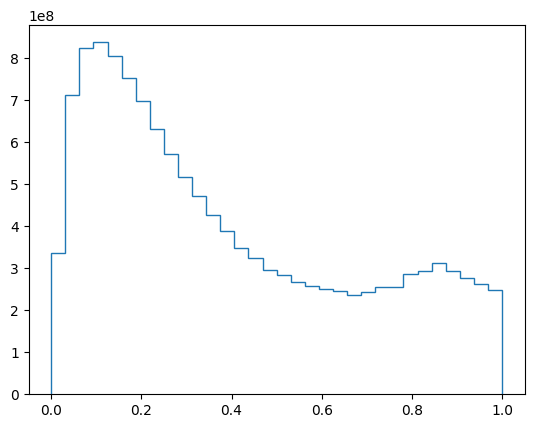

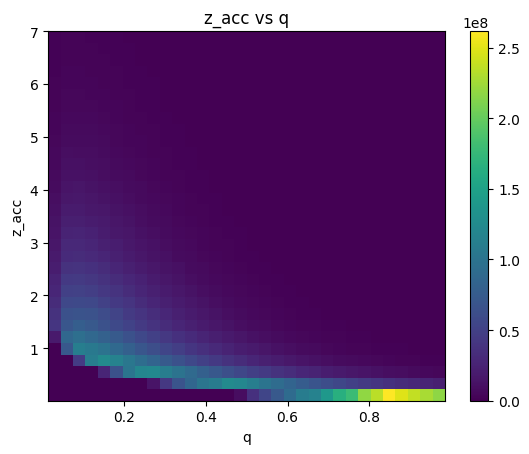

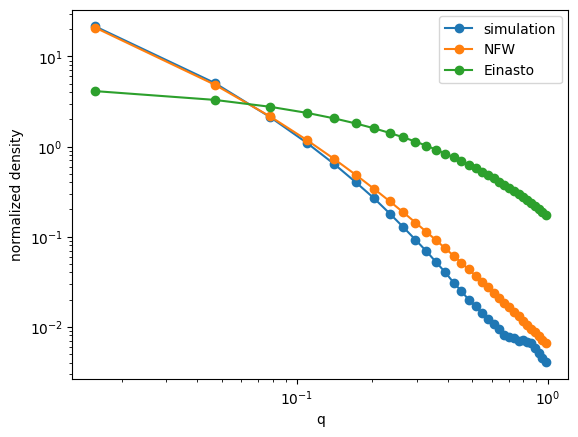

Setting k from 1.0 to 0.004060725481911017Setting k from 1.0 to 0.10483390880479526Setting k from 1.0 to 0.015088322912099644Setting k from 1.0 to 0.030316277330102087
Setting k from 1.0 to 0.6629520704683564



Setting k from 1.0 to 0.5718148231150156
Setting k from 1.0 to 0.4130735339660268
Setting k from 1.0 to 0.22963125873593526Setting k from 1.0 to 0.1404191031347104
Setting k from 1.0 to 0.07484219411136435
Setting k from 1.0 to 0.34491933735254876

Setting k from 1.0 to 0.28386789829614956Setting k from 1.0 to 0.4886129029257596

Setting k from 1.0 to 0.1819153162679548


  0%|          | 0/700 [00:00<?, ?it/s]

Setting k from 1.0 to 0.05011622043789778Setting k from 1.0 to 0.7622931909947745

  0%|          | 0/700 [00:00<?, ?it/s]

100%|██████████| 700/700 [00:00<00:00, 824.12it/s] 


Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]
Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]
Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]
Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]
Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...

 49%|████▉     | 344/700 [00:00<00:00, 1145.82it/s]

Setting k from 1.0 to 0.9866419904556671


 49%|████▉     | 344/700 [00:00<00:00, 1148.12it/s]

Setting k from 1.0 to 1.1121683340735655


 33%|███▎      | 232/700 [00:00<00:00, 1155.34it/s]

Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]


100%|██████████| 700/700 [00:00<00:00, 1145.25it/s]


Setting k from 1.0 to 1.2469363523742556


 66%|██████▌   | 463/700 [00:00<00:00, 1135.37it/s]

Setting k from 1.0 to 1.3911975901074103


 48%|████▊     | 333/700 [00:00<00:00, 1114.22it/s]

Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]


 33%|███▎      | 232/700 [00:00<00:00, 1141.63it/s]

Setting k from 1.0 to 1.5452008176818068


 32%|███▏      | 225/700 [00:00<00:00, 1125.43it/s]

Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]


 83%|████████▎ | 578/700 [00:00<00:00, 1113.81it/s]

Setting k from 1.0 to 1.7091921910797192


 82%|████████▏ | 571/700 [00:00<00:00, 1141.94it/s]

Setting k from 1.0 to 1.8834153965354263


 43%|████▎     | 302/700 [00:00<00:00, 1024.58it/s]

Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]


 74%|███████▍  | 520/700 [00:00<00:00, 1062.39it/s]

Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]


 49%|████▉     | 346/700 [00:00<00:00, 1143.30it/s]

Setting k from 1.0 to 2.0681117819500447


 30%|███       | 212/700 [00:00<00:00, 1014.16it/s]

Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]
Setting k from 1.0 to 2.2635204766976416


 78%|███████▊  | 547/700 [00:00<00:00, 1092.97it/s]

Setting k from 1.0 to 2.469878501220608


 45%|████▍     | 314/700 [00:00<00:00, 1073.75it/s]

Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]


 77%|███████▋  | 540/700 [00:00<00:00, 1105.07it/s]

Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]
Setting k from 1.0 to 2.687420867602458


 77%|███████▋  | 539/700 [00:00<00:00, 1050.13it/s]

Setting k from 1.0 to 2.916380672133675


 16%|█▌        | 112/700 [00:00<00:00, 1110.71it/s]

Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]


 96%|█████████▋| 675/700 [00:00<00:00, 1097.58it/s]

Setting k from 1.0 to 3.1569891807434063


  0%|          | 0/700 [00:00<?, ?it/s]

Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]


 97%|█████████▋| 676/700 [00:00<00:00, 1126.09it/s]

Setting k from 1.0 to 3.4094759080507577


100%|██████████| 700/700 [00:00<00:00, 1118.89it/s]


Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]


 33%|███▎      | 228/700 [00:00<00:00, 1040.40it/s]

Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]
Setting k from 1.0 to 3.674068690689757


100%|██████████| 700/700 [00:00<00:00, 1100.86it/s]


Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]


100%|██████████| 700/700 [00:00<00:00, 1095.95it/s]


Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]
Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]
Nrand: 1000 iMmax shape: (200, 700), iMax: [[ 66  32  21 ...   0   0   0]
 [ 81  39  25 ...   0   0   0]
 [ 96  46  30 ...   0   0   0]
 ...
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]
 [999 999 999 ... 869 869 869]]
mask 4483290 out of 56000000
q


array([0.015625, 0.015625, 0.015625, ..., 0.984375, 0.984375, 0.984375])

weight


array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       7.21689648e-12, 4.30012551e-12, 2.55403591e-12])

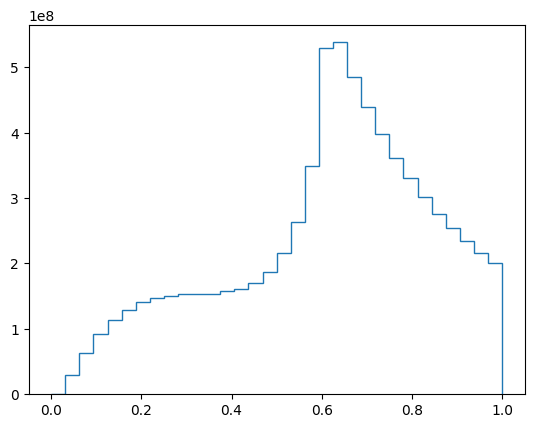

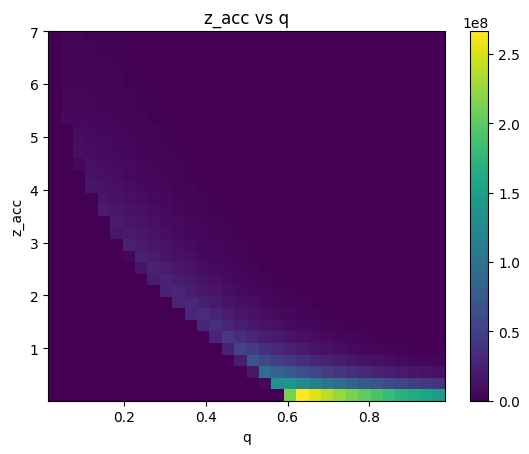

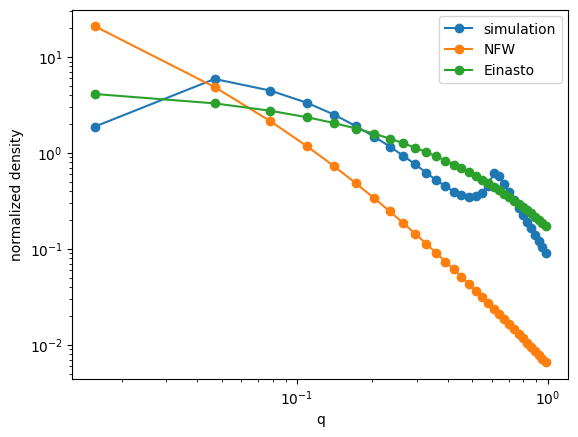

In [25]:
bins = np.linspace(0,1,32+1)
plot_hist(32,bins,m0_min=1e-1,m0_max=1e0,mdot_fitting_type=2)
plot_hist(32,bins,m0_min=1e-1,m0_max=1e0,mdot_fitting_type=2,A=0.6172, alpha=18.0172)

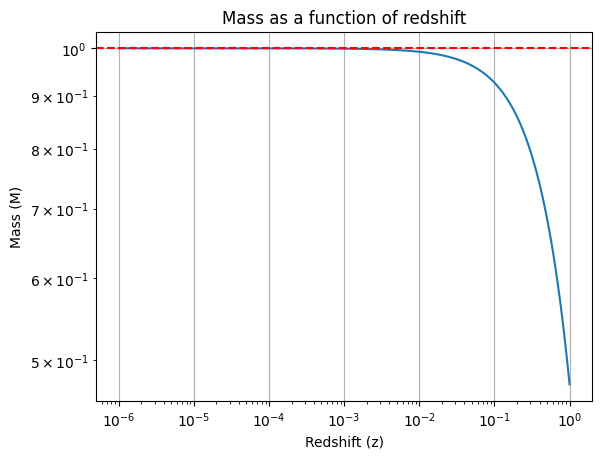

In [32]:
import matplotlib.pyplot as plt
import numpy as np

z = np.logspace(-6, 0, 1024)
Mhost = 1e12  # Host mass in solar masses
m = sh.Mzzi(Mhost, z, 0)
plt.plot(z, m/Mhost, label='Mzzi(Mhost, z, 0)')
plt.axhline(1, color='r', linestyle='--', label='Mhost')
plt.xlabel('Redshift (z)')
plt.ylabel('Mass (M)')
plt.title('Mass as a function of redshift')
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.show()

Setting k from 1.0 to 1.8834153965354263Setting k from 1.0 to 1.1121683340735655Setting k from 1.0 to 0.015088322912099644


Setting k from 1.0 to 0.004060725481911017Setting k from 1.0 to 0.7622931909947745Setting k from 1.0 to 0.030316277330102087


Setting k from 1.0 to 0.4886129029257596
Setting k from 1.0 to 3.674068690689757Setting k from 1.0 to 2.2635204766976416

Setting k from 1.0 to 0.9866419904556671
Setting k from 1.0 to 0.1404191031347104Setting k from 1.0 to 0.4130735339660268

Setting k from 1.0 to 0.10483390880479526Setting k from 1.0 to 2.469878501220608



  0%|          | 0/700 [00:00<?, ?it/s]

Setting k from 1.0 to 0.05011622043789778

  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Setting k from 1.0 to 0.28386789829614956
Setting k from 1.0 to 0.07484219411136435Setting k from 1.0 to 0.1819153162679548Setting k from 1.0 to 1.2469363523742556
Setting k from 1.0 to 0.5718148231150156
Setting k from 1.0 to 0.34491933735254876

  0%|          | 0/700 [00:00<?, ?it/s]


Setting k from 1.0 to 3.4094759080507577Setting k from 1.0 to 2.687420867602458
Setting k from 1.0 to 1.7091921910797192Setting k from 1.0 to 0.8701028249126376
Setting k from 1.0 to 2.916380672133675



Setting k from 1.0 to 0.22963125873593526



  0%|          | 0/700 [00:00<?, ?it/s]

Setting k from 1.0 to 0.6629520704683564

  0%|          | 0/700 [00:00<?, ?it/s]


Setting k from 1.0 to 2.0681117819500447Setting k from 1.0 to 3.1569891807434063

  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Setting k from 1.0 to 1.3911975901074103
Setting k from 1.0 to 1.5452008176818068


100%|██████████| 700/700 [00:00<00:00, 1071.46it/s]

100%|██████████| 700/700 [00:00<00:00, 1068.93it/s]

100%|██████████| 700/700 [00:00<00:00, 1077.68it/s]




100%|██████████| 700/700 [00:00<00:00, 1012.62it/s]

100%|██████████| 700/700 [00:00<00:00, 958.01it/s] 

100%|██████████| 700/700 [00:00<00:00, 737.05it/s]

100%|██████████| 700/700 [00:01<00:00, 682.58it/s]

100%|██████████| 700/700 [00:01<00:00, 593.66it/s]


mask 4483290 out of 56000000
q


array([0.015625, 0.015625, 0.015625, ..., 0.984375, 0.984375, 0.984375])

weight


array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       7.43733276e-12, 4.43147056e-12, 2.63204759e-12])

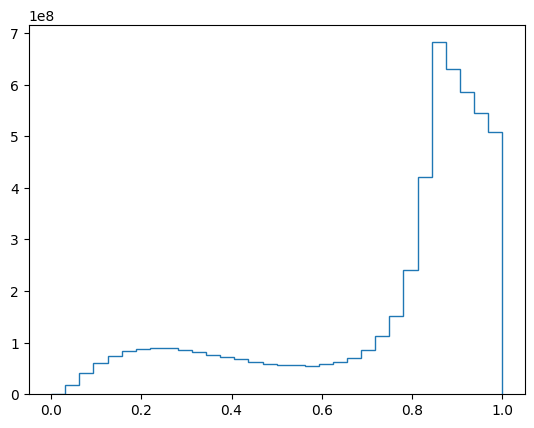

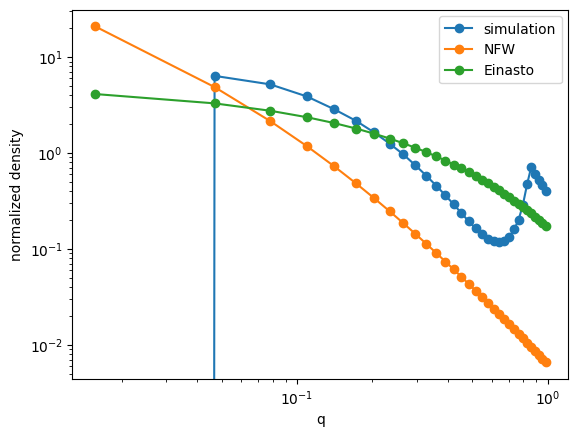

In [8]:
plot_hist(32,bins,m0_min=1e-1,m0_max=1e0,
          mdot_fitting_type=2,
          A=0.85, alpha=18.0172)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# print(np.array(results[4]))

def einasto(r,alpha = 0.678 , r_2 = 0.81,N=1):
    power = (-2/alpha)*((r/r_2)**alpha-1)
    return N*np.exp(power)  

# plot density profile
def get_hist(q_bin,bins,m0_min, m0_max,
              mdot_fitting_type=0,
              A=0.85,alpha=1.8):
    results = sh.subhalo_properties_r_dependence_calc(
        1e12,q_bin=q_bin,
        dz=0.01,
        logmamin=-2,
        N_herm=5,
        mdot_fitting_type=mdot_fitting_type,
        A=A,alpha=alpha)
    # unpack results
    (
        ma200, 
        z_acc, 
        rs_acc, 
        rhos_acc, 
        m_z0, 
        rs_z0, 
        rhos_z0, 
        ct_z0, 
        weight_combined, 
        density, 
        survive, 
        q
    ) = results
    q = q.reshape(-1)
    w = weight_combined.reshape(-1)
    m0 = np.array(m_z0).reshape(-1)
    mask = np.array(survive).reshape(-1)  # survive
    mask = mask & np.array(m0 > m0_min).reshape(-1)   # only plot for m0 > m0_min
    mask = mask & np.array(m0 < m0_max).reshape(-1)
    print('mask', mask.sum(), 'out of', mask.size)
    # ma200 vs m_z0
    # plt.figure(figsize=(8, 6))
    # print(mask)
    # plt.scatter(np.array(m_z0).flatten()[mask], np.array(ma200).flatten()[mask], s=1, c='k', alpha=0.1)
    # plt.xlabel('m_z0')
    # plt.ylabel('ma200')
    # plt.xscale('log')
    # plt.yscale('log')
    # plt.title('ma200 vs m_z0')
    # plt.show()
    # q vs m_z0
    ret = np.histogram(q[mask],
                 weights=w[mask],
                 bins=bins,
                 density=True)
    return ret

def hyperparameter_tuning(q_bin, bins, m0_min, m0_max, 
                          mdot_fitting_type=0, log_file="optimization.log"):
    import logging
    import datetime
    import os
    
    # 既存のログハンドラーをクリア（重複を防ぐため）
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
    
    # VSCode Log Viewer用のフォーマット設定
    log_format = '%(asctime)s [%(levelname)s] %(message)s'
    date_format = '%Y-%m-%d %H:%M:%S'
    
    # ログファイルの設定
    file_handler = logging.FileHandler(log_file, mode='a')
    console_handler = logging.StreamHandler()
    
    # フォーマッターを設定
    formatter = logging.Formatter(log_format, datefmt=date_format)
    file_handler.setFormatter(formatter)
    console_handler.setFormatter(formatter)
    
    # ルートロガーを設定
    root_logger = logging.getLogger()
    root_logger.setLevel(logging.INFO)
    root_logger.addHandler(file_handler)
    root_logger.addHandler(console_handler)
    
    # ログファイルの初期化（ヘッダー情報を追加）
    root_logger.info("="*60)
    root_logger.info("HYPERPARAMETER OPTIMIZATION LOG")
    root_logger.info("="*60)
    
    # loss_function呼び出し回数をカウント
    call_count = 0
    
    def loss_function(params):
        nonlocal call_count
        call_count += 1
        
        A, alpha = params
        hist_ret = get_hist(q_bin, bins, m0_min, m0_max,
                            mdot_fitting_type=mdot_fitting_type,
                            A=A, alpha=alpha)
        val = hist_ret[0]
        edges = hist_ret[1]
        centers = (edges[1:] + edges[:-1]) / 2
        dq = edges[1:] - edges[:-1]
        val = val/(4*np.pi*centers**2*dq)
        val = val / np.exp(np.log(val.mean()))
        # Calculate the loss as the difference from a target profile
        target_profile = einasto(centers)
        target_profile = target_profile / np.exp(np.log(target_profile.mean()))
        loss = np.sum((np.log10(val) - np.log10(target_profile))**2)
        
        # loss_function呼び出し時にログを記録
        log_message = f"Function call {call_count}: A={A:.4f}, alpha={alpha:.4f}, loss={loss:.6f}"
        root_logger.info(log_message)
        
        # ログファイルに強制的に書き込み
        for handler in root_logger.handlers:
            if isinstance(handler, logging.FileHandler):
                handler.flush()
        
        return loss
    
    # 最適化開始のログ
    root_logger.info(f"Parameters: q_bin={q_bin}, m0_min={m0_min}, m0_max={m0_max}, mdot_fitting_type={mdot_fitting_type}")
    
    # minimize the loss function
    from scipy.optimize import minimize
    initial_guess = [1,1]
    
    start_message = f"Starting optimization with initial guess: A={initial_guess[0]}, alpha={initial_guess[1]}"
    root_logger.info(start_message)
    root_logger.info(f"Logging to file: {log_file}")
    
    # callbackは使わずにloss_function内でログを記録
    result = minimize(loss_function, initial_guess, method='Nelder-Mead')
    
    if result.success:
        optimized_params = result.x
        final_loss = loss_function(optimized_params)
        success_message = f"Optimization successful! A={optimized_params[0]:.4f}, alpha={optimized_params[1]:.4f}, final_loss={final_loss:.6f}"
        root_logger.info(success_message)
        root_logger.info(f"Total function calls: {call_count}")
        root_logger.info("="*60)
        
        # 最後にログファイルをフラッシュ
        for handler in root_logger.handlers:
            if isinstance(handler, logging.FileHandler):
                handler.flush()
        
        return optimized_params
    else:
        failure_message = "Optimization failed."
        root_logger.error(failure_message)
        root_logger.info(f"Total function calls: {call_count}")
        root_logger.info("="*60)
        
        # 最後にログファイルをフラッシュ
        for handler in root_logger.handlers:
            if isinstance(handler, logging.FileHandler):
                handler.flush()
        
        return None

hyperparameter_tuning(q_bin=32,
                      bins=np.linspace(0,1,32+1),
                      m0_min=1e-1,
                      m0_max=1e0,
                      mdot_fitting_type=2,
                      log_file="optimization.log")


2025-07-02 18:55:35 [INFO] ============================================================
2025-07-02 18:55:35 [INFO] HYPERPARAMETER OPTIMIZATION LOG
2025-07-02 18:55:35 [INFO] ============================================================
2025-07-02 18:55:35 [INFO] Parameters: q_bin=32, m0_min=0.1, m0_max=1.0, mdot_fitting_type=2
2025-07-02 18:55:35 [INFO] Starting optimization with initial guess: A=1, alpha=1
2025-07-02 18:55:35 [INFO] Logging to file: optimization.log


Setting k from 1.0 to 0.004060725481911017Setting k from 1.0 to 0.030316277330102087Setting k from 1.0 to 0.015088322912099644Setting k from 1.0 to 0.05011622043789778Setting k from 1.0 to 0.1819153162679548Setting k from 1.0 to 0.1404191031347104
Setting k from 1.0 to 0.4886129029257596


Setting k from 1.0 to 1.2469363523742556

Setting k from 1.0 to 0.8701028249126376Setting k from 1.0 to 0.07484219411136435



Setting k from 1.0 to 1.7091921910797192Setting k from 1.0 to 1.8834153965354263
Setting k from 1.0 to 3.674068690689757

Setting k from 1.0 to 0.10483390880479526Setting k from 1.0 to 0.28386789829614956
Setting k from 1.0 to 0.5718148231150156Setting k from 1.0 to 0.34491933735254876Setting k from 1.0 to 0.7622931909947745Setting k from 1.0 to 0.6629520704683564Setting k from 1.0 to 0.4130735339660268



Setting k from 1.0 to 1.3911975901074103Setting k from 1.0 to 0.22963125873593526
Setting k from 1.0 to 2.2635204766976416
Setting k from 1.0 to 2.0681117819500447Setting k

  0%|          | 0/700 [00:00<?, ?it/s]

Setting k from 1.0 to 1.1121683340735655


  0%|          | 0/700 [00:00<?, ?it/s]

Setting k from 1.0 to 0.9866419904556671


100%|██████████| 700/700 [00:00<00:00, 1024.31it/s]

100%|██████████| 700/700 [00:00<00:00, 1020.47it/s]


100%|██████████| 700/700 [00:00<00:00, 854.93it/s] 



100%|██████████| 700/700 [00:01<00:00, 691.18it/s]

100%|██████████| 700/700 [00:01<00:00, 691.21it/s]


100%|██████████| 700/700 [00:01<00:00, 663.39it/s]

100%|██████████| 700/700 [00:01<00:00, 541.30it/s]

Exception ignored in: <function Pool.__del__ at 0x7f1857bfb9c0>
Traceback (most recent call last):
  File "/home/gomesu/workspace/sashimi-c/.conda/lib/python3.11/multiprocessing/pool.py", line 266, in __del__
    def __del__(self, _warn=warnings.warn, RUN=RUN):

KeyboardInterrupt: 


mask 4483290 out of 56000000


2025-07-02 18:56:14 [INFO] Function call 1: A=1.0000, alpha=1.0000, loss=358.098371


Setting k from 1.0 to 0.015088322912099644Setting k from 1.0 to 0.030316277330102087

Setting k from 1.0 to 0.05011622043789778Setting k from 1.0 to 0.07484219411136435Setting k from 1.0 to 0.34491933735254876Setting k from 1.0 to 0.1819153162679548Setting k from 1.0 to 0.22963125873593526Setting k from 1.0 to 0.4130735339660268Setting k from 1.0 to 0.4886129029257596

Setting k from 1.0 to 0.8701028249126376Setting k from 1.0 to 0.6629520704683564Setting k from 1.0 to 1.5452008176818068


Setting k from 1.0 to 1.7091921910797192Setting k from 1.0 to 1.8834153965354263Setting k from 1.0 to 2.2635204766976416Setting k from 1.0 to 1.3911975901074103

Setting k from 1.0 to 0.7622931909947745


Setting k from 1.0 to 0.1404191031347104



Setting k from 1.0 to 2.469878501220608Setting k from 1.0 to 2.687420867602458Setting k from 1.0 to 3.1569891807434063
Setting k from 1.0 to 2.916380672133675Setting k from 1.0 to 1.2469363523742556Setting k from 1.0 to 3.4094759080507577






Setting k f

  0%|          | 0/700 [00:00<?, ?it/s]

Setting k from 1.0 to 0.9866419904556671Setting k from 1.0 to 1.1121683340735655



100%|██████████| 700/700 [00:00<00:00, 1013.39it/s]

100%|██████████| 700/700 [00:00<00:00, 1008.47it/s]

100%|██████████| 700/700 [00:00<00:00, 1009.63it/s]

 97%|█████████▋| 678/700 [00:00<00:00, 973.09it/s]

 87%|████████▋ | 608/700 [00:00<00:00, 924.70it/s] 

100%|██████████| 700/700 [00:00<00:00, 985.55it/s]

 88%|████████▊ | 613/700 [00:00<00:00, 937.33it/s] 


100%|██████████| 700/700 [00:00<00:00, 708.51it/s]

100%|██████████| 700/700 [00:01<00:00, 610.37it/s]


In [ ]:
# ログファイルを読み込んで表示する便利な関数
def read_optimization_log(log_file="optimization.log"):
    """
    最適化ログファイルを読み込んで表示する
    """
    try:
        with open(log_file, 'r') as f:
            content = f.read()
            print(f"=== Log file: {log_file} ===")
            print(content)
    except FileNotFoundError:
        print(f"Log file '{log_file}' not found.")

def clear_optimization_log(log_file="optimization.log"):
    """
    ログファイルをクリアする
    """
    try:
        with open(log_file, 'w') as f:
            f.write("")
        print(f"Log file '{log_file}' cleared.")
    except Exception as e:
        print(f"Error clearing log file: {e}")

def tail_optimization_log(log_file="optimization.log", n_lines=10):
    """
    ログファイルの最後のn行を表示する
    """
    try:
        with open(log_file, 'r') as f:
            lines = f.readlines()
            if len(lines) <= n_lines:
                print(f"=== Last {len(lines)} lines of {log_file} ===")
                print(''.join(lines))
            else:
                print(f"=== Last {n_lines} lines of {log_file} ===")
                print(''.join(lines[-n_lines:]))
    except FileNotFoundError:
        print(f"Log file '{log_file}' not found.")

In [1]:
# ログファイルの状態を確認するデバッグ関数
def check_log_file_status(log_file="optimization.log"):
    """
    ログファイルの状態を確認する
    """
    import os
    print(f"=== Log File Status: {log_file} ===")
    
    if os.path.exists(log_file):
        file_size = os.path.getsize(log_file)
        print(f"✓ File exists: {log_file}")
        print(f"✓ File size: {file_size} bytes")
        
        if file_size > 0:
            print("✓ File has content")
            # 最初の数行を表示
            with open(log_file, 'r') as f:
                lines = f.readlines()
                print(f"✓ Total lines: {len(lines)}")
                print("--- First 5 lines ---")
                for i, line in enumerate(lines[:5]):
                    print(f"{i+1}: {line.strip()}")
        else:
            print("⚠ File is empty")
    else:
        print(f"✗ File does not exist: {log_file}")
    
    print()

def test_logging(log_file="optimization.log"):
    """
    ログ機能をテストする
    """
    import logging
    import datetime
    
    # 既存のハンドラーをクリア
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
    
    # ログ設定
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s [%(levelname)s] %(message)s',
        datefmt='%Y-%m-%d %H:%M:%S',
        handlers=[
            logging.FileHandler(log_file, mode='a'),
            logging.StreamHandler()
        ]
    )
    
    logger = logging.getLogger(__name__)
    
    print(f"Testing log functionality...")
    logger.info("=== LOG TEST START ===")
    logger.info("This is a test log message")
    logger.warning("This is a test warning")
    logger.error("This is a test error")
    logger.info("=== LOG TEST END ===")
    print(f"Test completed. Check {log_file}")

# ログファイルの状態をチェック
check_log_file_status("optimization.log")

# ログ機能をテスト
test_logging("optimization.log")

2025-07-02 18:07:39 [INFO] === LOG TEST START ===
2025-07-02 18:07:39 [INFO] This is a test log message
2025-07-02 18:07:39 [WARNING] This is a test warning
2025-07-02 18:07:39 [ERROR] This is a test error
2025-07-02 18:07:39 [INFO] === LOG TEST END ===


=== Log File Status: optimization.log ===
✗ File does not exist: optimization.log

Testing log functionality...
Test completed. Check optimization.log


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


  0%|          | 0/700 [00:00<?, ?it/s]988.48it/s]

Setting k from 1.0 to 1.3772623126546313


100%|██████████| 700/700 [00:00<00:00, 818.37it/s]


Setting k from 1.0 to 1.2809265382443409
Setting k from 1.0 to 1.2372765168706303


 25%|██▍       | 174/700 [00:00<00:00, 862.91it/s]

Setting k from 1.0 to 1.1966296133084773
Setting k from 1.0 to 1.158961918636764


 41%|████      | 285/700 [00:00<00:00, 894.15it/s] 

Setting k from 1.0 to 1.1242357835052785


 23%|██▎       | 164/700 [00:00<00:00, 817.98it/s]

Setting k from 1.0 to 1.092400106219814
Setting k from 1.0 to 1.0633907706590056


 83%|████████▎ | 582/700 [00:00<00:00, 597.53it/s]

Setting k from 1.0 to 1.0371312121032628


 15%|█▍        | 103/700 [00:00<00:01, 515.86it/s]

Setting k from 1.0 to 1.0135330848638746


  0%|          | 0/700 [00:00<?, ?it/s]626.39it/s]

Setting k from 1.0 to 0.9924970030118169


 42%|████▏     | 297/700 [00:00<00:00, 657.88it/s]

Setting k from 1.0 to 0.973913324575567


  0%|          | 0/700 [00:00<?, ?it/s]617.26it/s]

Setting k from 1.0 to 0.9576629501605277


 38%|███▊      | 265/700 [00:00<00:00, 507.26it/s]

Setting k from 1.0 to 0.9436181087066252


 14%|█▎        | 95/700 [00:00<00:01, 478.75it/s]]

Setting k from 1.0 to 0.931643105552343


 69%|██████▉   | 485/700 [00:00<00:00, 651.93it/s]

Setting k from 1.0 to 0.9215950104924896


 10%|█         | 72/700 [00:00<00:00, 719.78it/s]]

Setting k from 1.0 to 0.9133242653674042


100%|██████████| 700/700 [00:01<00:00, 628.04it/s]


Setting k from 1.0 to 0.9066751910058051


100%|██████████| 700/700 [00:01<00:00, 621.90it/s]


Setting k from 1.0 to 0.9014863708263399


  0%|          | 0/700 [00:00<?, ?it/s]530.58it/s]

Setting k from 1.0 to 0.8975908810340103


 23%|██▎       | 164/700 [00:00<00:00, 822.37it/s]

Setting k from 1.0 to 0.8948163210241705


 47%|████▋     | 329/700 [00:00<00:00, 765.60it/s]

Setting k from 1.0 to 0.8929845626910152


 68%|██████▊   | 479/700 [00:00<00:00, 657.90it/s]

Setting k from 1.0 to 0.8919110572867149


 55%|█████▍    | 383/700 [00:00<00:00, 679.32it/s]

Setting k from 1.0 to 0.8914033231628363


 93%|█████████▎| 653/700 [00:01<00:00, 624.29it/s]

Setting k from 1.0 to 0.8912574485946476


100%|██████████| 700/700 [00:01<00:00, 658.25it/s]


mask 4475300 out of 56000000


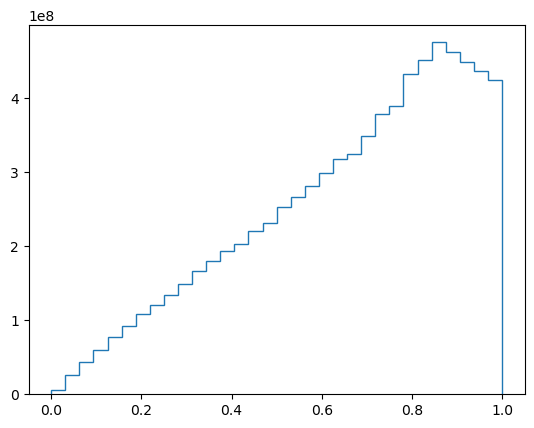

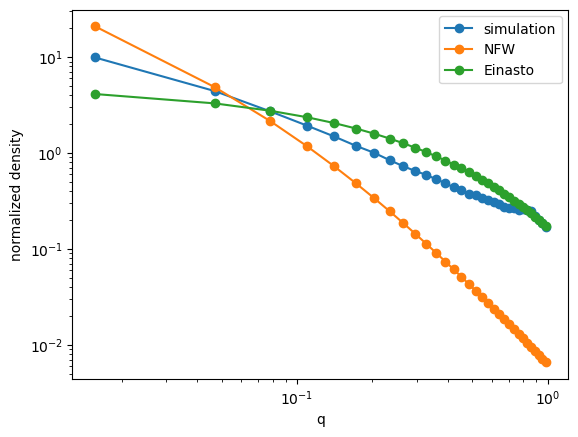

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


100%|██████████| 700/700 [00:01<00:00, 672.24it/s]


Setting k from 1.0 to 1.2809265382443409


  0%|          | 0/700 [00:00<?, ?it/s]588.51it/s]

Setting k from 1.0 to 1.2372765168706303


 47%|████▋     | 330/700 [00:00<00:00, 715.75it/s]

Setting k from 1.0 to 1.1966296133084773


100%|██████████| 700/700 [00:00<00:00, 715.22it/s]


Setting k from 1.0 to 1.158961918636764
Setting k from 1.0 to 1.1242357835052785

  0%|          | 0/700 [00:00<?, ?it/s]830.40it/s]

 23%|██▎       | 158/700 [00:00<00:00, 718.04it/s]

Setting k from 1.0 to 1.092400106219814


 11%|█         | 74/700 [00:00<00:01, 362.44it/s]]

Setting k from 1.0 to 1.0633907706590056


 23%|██▎       | 159/700 [00:00<00:01, 399.05it/s]

Setting k from 1.0 to 1.0371312121032628


 17%|█▋        | 122/700 [00:00<00:00, 619.18it/s]

Setting k from 1.0 to 1.0135330848638746


 35%|███▍      | 242/700 [00:00<00:00, 562.76it/s]

Setting k from 1.0 to 0.9924970030118169


 17%|█▋        | 119/700 [00:00<00:00, 603.64it/s]

Setting k from 1.0 to 0.973913324575567


 53%|█████▎    | 370/700 [00:00<00:00, 457.05it/s]

Setting k from 1.0 to 0.9576629501605277


  0%|          | 0/700 [00:00<?, ?it/s]555.46it/s]

Setting k from 1.0 to 0.9436181087066252


 79%|███████▉  | 552/700 [00:00<00:00, 661.32it/s]

Setting k from 1.0 to 0.931643105552343


 51%|█████▏    | 360/700 [00:00<00:00, 659.31it/s]

Setting k from 1.0 to 0.9215950104924896


 75%|███████▍  | 523/700 [00:00<00:00, 750.45it/s]

Setting k from 1.0 to 0.9133242653674042


 23%|██▎       | 158/700 [00:00<00:00, 837.55it/s]

Setting k from 1.0 to 0.9066751910058051


 19%|█▉        | 136/700 [00:00<00:00, 665.17it/s]

Setting k from 1.0 to 0.9014863708263399


 38%|███▊      | 266/700 [00:00<00:00, 602.51it/s]

Setting k from 1.0 to 0.8975908810340103


  0%|          | 0/700 [00:00<?, ?it/s]

Setting k from 1.0 to 0.8948163210241705


100%|██████████| 700/700 [00:01<00:00, 556.26it/s]


Setting k from 1.0 to 0.8929845626910152


 51%|█████     | 357/700 [00:00<00:00, 506.71it/s]

Setting k from 1.0 to 0.8919110572867149


 69%|██████▉   | 486/700 [00:00<00:00, 607.11it/s]

Setting k from 1.0 to 0.8914033231628363


100%|██████████| 700/700 [00:01<00:00, 631.39it/s]


Setting k from 1.0 to 0.8912574485946476


100%|██████████| 700/700 [00:01<00:00, 548.51it/s]


mask 4475300 out of 56000000


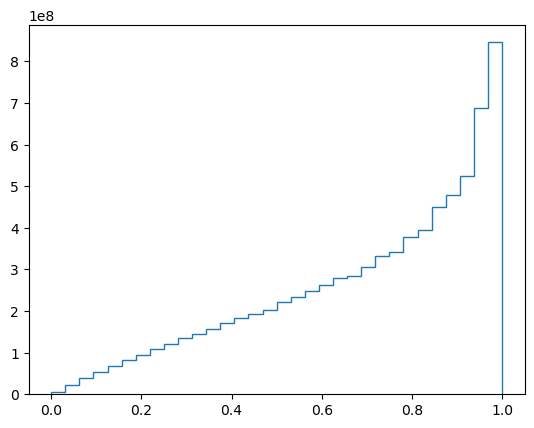

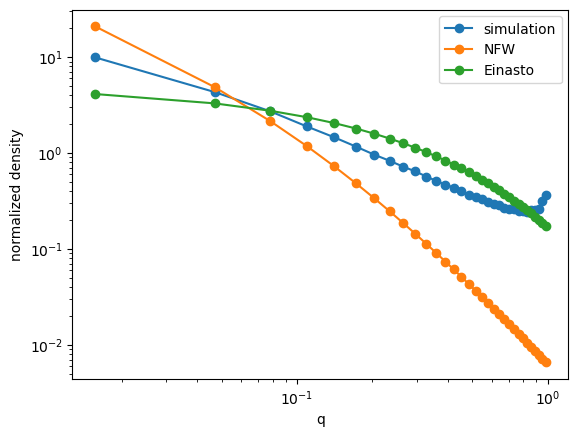

In [ ]:
# bins = np.logspace(-2,0,64)
plot_hist(32,bins,m0_min=1e-1,m0_max=1e0,mdot_fitting_type=0,A=0.85,alpha=1.8)
plot_hist(32,bins,m0_min=1e-1,m0_max=1e0,mdot_fitting_type=0,A=1.00,alpha=1.8)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


  0%|          | 0/700 [00:00<?, ?it/s]

Setting k from 1.0 to 1.2786615184727914
Setting k from 1.0 to 1.2380758096170688


  0%|          | 0/700 [00:00<?, ?it/s]1059.30it/s]

Setting k from 1.0 to 1.2026581174553928
Setting k from 1.0 to 1.1713446814818496


100%|██████████| 700/700 [00:00<00:00, 980.03it/s] 


Setting k from 1.0 to 1.1433604880274832


 19%|█▉        | 135/700 [00:00<00:00, 672.70it/s]

Setting k from 1.0 to 1.1181248272259217


 42%|████▏     | 292/700 [00:00<00:00, 584.93it/s]

Setting k from 1.0 to 1.0951922528155011


 14%|█▎        | 95/700 [00:00<00:01, 478.59it/s]]

Setting k from 1.0 to 1.0742142054338777


100%|██████████| 700/700 [00:01<00:00, 469.46it/s]


Setting k from 1.0 to 1.054913232083926


 89%|████████▊ | 620/700 [00:00<00:00, 569.91it/s]

Setting k from 1.0 to 1.0370651721277546


  0%|          | 0/700 [00:00<?, ?it/s]630.53it/s]

Setting k from 1.0 to 1.020486543741273


 44%|████▍     | 307/700 [00:00<00:00, 744.26it/s]

Setting k from 1.0 to 1.0050254197987296


100%|██████████| 700/700 [00:01<00:00, 561.08it/s]


Setting k from 1.0 to 0.9905547022692794


 27%|██▋       | 190/700 [00:00<00:00, 962.67it/s]

Setting k from 1.0 to 0.976967080822012


 37%|███▋      | 256/700 [00:00<00:00, 726.43it/s]

Setting k from 1.0 to 0.9641711967660462


 58%|█████▊    | 406/700 [00:00<00:00, 795.15it/s]

Setting k from 1.0 to 0.9520886844495814


100%|██████████| 700/700 [00:01<00:00, 519.48it/s]


Setting k from 1.0 to 0.9406518613353702


 17%|█▋        | 119/700 [00:00<00:00, 592.01it/s]

Setting k from 1.0 to 0.9298019043592057


 33%|███▎      | 230/700 [00:00<00:01, 454.71it/s]

Setting k from 1.0 to 0.9194873954962401


  0%|          | 0/700 [00:00<?, ?it/s]468.92it/s]

Setting k from 1.0 to 0.9096631509257994


100%|██████████| 700/700 [00:01<00:00, 519.58it/s]


Setting k from 1.0 to 0.9002892703754356


100%|██████████| 700/700 [00:00<00:00, 917.98it/s] 


Setting k from 1.0 to 0.8913303590984867


  7%|▋         | 49/700 [00:00<00:01, 478.36it/s]

Setting k from 1.0 to 0.8827548864445609


 31%|███       | 216/700 [00:00<00:00, 511.13it/s]

Setting k from 1.0 to 0.8745346534231188


100%|██████████| 700/700 [00:01<00:00, 588.59it/s]


mask 4488075 out of 56000000


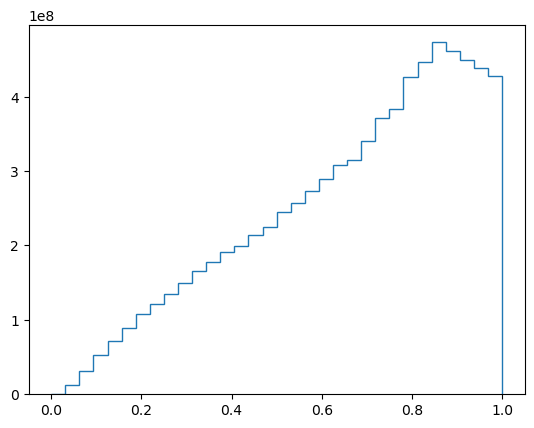

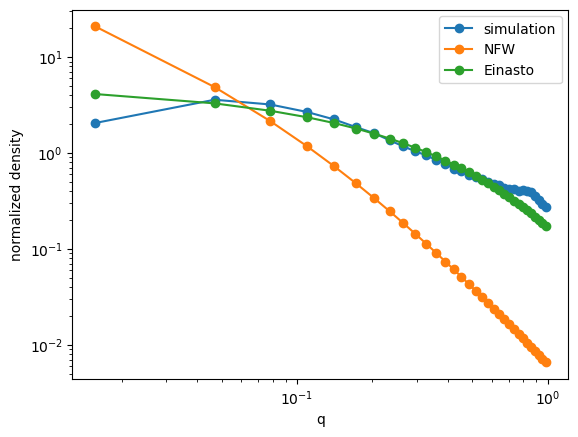

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


100%|██████████| 700/700 [00:01<00:00, 490.45it/s]


Setting k from 1.0 to 1.2786615184727914
Setting k from 1.0 to 1.2380758096170688


  0%|          | 0/700 [00:00<?, ?it/s]1014.96it/s]

Setting k from 1.0 to 1.2026581174553928


  0%|          | 0/700 [00:00<?, ?it/s]1006.61it/s]

Setting k from 1.0 to 1.1713446814818496


100%|██████████| 700/700 [00:00<00:00, 1004.77it/s]


Setting k from 1.0 to 1.1433604880274832
Setting k from 1.0 to 1.1181248272259217


 22%|██▏       | 151/700 [00:00<00:00, 753.19it/s]

Setting k from 1.0 to 1.0951922528155011
Setting k from 1.0 to 1.0742142054338777


100%|██████████| 700/700 [00:01<00:00, 621.41it/s]


Setting k from 1.0 to 1.054913232083926


  0%|          | 0/700 [00:00<?, ?it/s]

Setting k from 1.0 to 1.0370651721277546


 25%|██▌       | 176/700 [00:00<00:01, 399.15it/s]

Setting k from 1.0 to 1.020486543741273


 48%|████▊     | 334/700 [00:00<00:00, 400.08it/s]

Setting k from 1.0 to 1.0050254197987296


  0%|          | 0/700 [00:00<?, ?it/s]627.63it/s]

Setting k from 1.0 to 0.9905547022692794
Setting k from 1.0 to 0.976967080822012


 92%|█████████▏| 645/700 [00:00<00:00, 602.68it/s]

Setting k from 1.0 to 0.9641711967660462


 88%|████████▊ | 619/700 [00:01<00:00, 490.57it/s]

Setting k from 1.0 to 0.9520886844495814


100%|██████████| 700/700 [00:01<00:00, 549.04it/s]


Setting k from 1.0 to 0.9406518613353702


 86%|████████▌ | 600/700 [00:01<00:00, 590.36it/s]

Setting k from 1.0 to 0.9298019043592057


 57%|█████▋    | 396/700 [00:00<00:00, 510.08it/s]

Setting k from 1.0 to 0.9194873954962401


 18%|█▊        | 124/700 [00:00<00:00, 615.13it/s]

Setting k from 1.0 to 0.9096631509257994


100%|██████████| 700/700 [00:00<00:00, 940.10it/s] 


Setting k from 1.0 to 0.9002892703754356


100%|██████████| 700/700 [00:02<00:00, 323.45it/s]


Setting k from 1.0 to 0.8913303590984867


  0%|          | 0/700 [00:00<?, ?it/s]593.63it/s]

Setting k from 1.0 to 0.8827548864445609


 80%|████████  | 563/700 [00:01<00:00, 493.01it/s]

Setting k from 1.0 to 0.8745346534231188


100%|██████████| 700/700 [00:02<00:00, 273.56it/s]


mask 4488075 out of 56000000


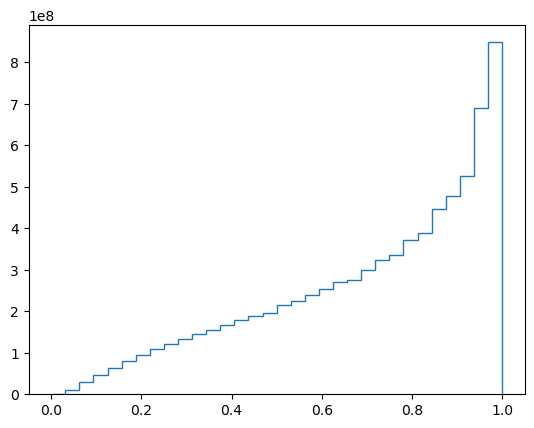

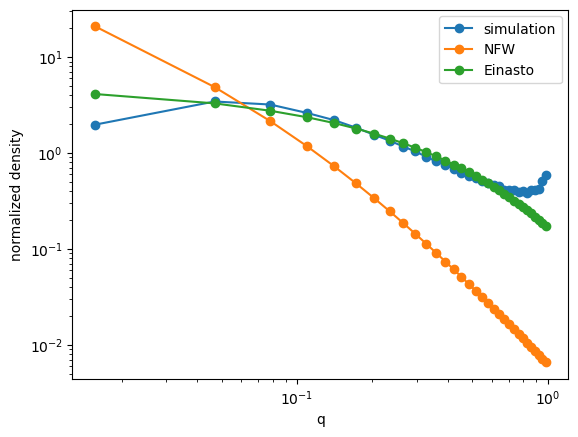

In [ ]:
# power-law m_dot?
plot_hist(32,bins,m0_min=1e-1,m0_max=1e0,mdot_fitting_type=1,A=0.85,alpha=1.8)
plot_hist(32,bins,m0_min=1e-1,m0_max=1e0,mdot_fitting_type=1,A=1.00,alpha=1.8)

In [ ]:
plot_hist(32,bins,m0_min=1e-1,m0_max=1e0,A=1.00,alpha=1.0)
plot_hist(32,bins,m0_min=1e-1,m0_max=1e0,A=1.00,alpha=0.5)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


 25%|██▍       | 173/700 [00:00<00:00, 873.26it/s]

Setting k from 1.0 to 2.1145629501447596
Setting k from 1.0 to 1.5376427846834075
Setting k from 1.0 to 1.3259260932297694
Setting k from 1.0 to 1.3821087302130723


100%|██████████| 700/700 [00:00<00:00, 814.14it/s]


Setting k from 1.0 to 1.2786615184727914


 84%|████████▍ | 590/700 [00:00<00:00, 1227.32it/s]

Setting k from 1.0 to 1.2380758096170688
Setting k from 1.0 to 1.2026581174553928


 47%|████▋     | 326/700 [00:00<00:00, 1033.87it/s]

Setting k from 1.0 to 1.1713446814818496


 92%|█████████▏| 644/700 [00:00<00:00, 980.55it/s] 

Setting k from 1.0 to 1.1433604880274832


  9%|▉         | 65/700 [00:00<00:00, 639.46it/s]]

Setting k from 1.0 to 1.1181248272259217


  0%|          | 0/700 [00:00<?, ?it/s]601.91it/s]

Setting k from 1.0 to 1.0951922528155011


 44%|████▎     | 306/700 [00:00<00:00, 636.40it/s]

Setting k from 1.0 to 1.0742142054338777


100%|██████████| 700/700 [00:01<00:00, 486.56it/s]


KeyboardInterrupt: 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


  0%|          | 0/700 [00:00<?, ?it/s]90.97it/s]s]

Setting k from 1.0 to 1.3259260932297694


100%|██████████| 700/700 [00:00<00:00, 795.78it/s]


Setting k from 1.0 to 1.2786615184727914
Setting k from 1.0 to 1.2380758096170688


 23%|██▎       | 159/700 [00:00<00:00, 793.40it/s]]

Setting k from 1.0 to 1.2026581174553928
Setting k from 1.0 to 1.1713446814818496


 85%|████████▍ | 594/700 [00:00<00:00, 736.34it/s]

Setting k from 1.0 to 1.1433604880274832


 30%|██▉       | 208/700 [00:00<00:00, 698.89it/s]

Setting k from 1.0 to 1.1181248272259217


 72%|███████▏  | 507/700 [00:00<00:00, 692.06it/s]

Setting k from 1.0 to 1.0951922528155011


 75%|███████▌  | 525/700 [00:00<00:00, 662.01it/s]

Setting k from 1.0 to 1.0742142054338777


100%|██████████| 700/700 [00:01<00:00, 660.05it/s]


Setting k from 1.0 to 1.054913232083926


 27%|██▋       | 191/700 [00:00<00:01, 344.54it/s]

Setting k from 1.0 to 1.0370651721277546


 61%|██████    | 425/700 [00:00<00:00, 585.97it/s]

Setting k from 1.0 to 1.020486543741273


 24%|██▍       | 168/700 [00:00<00:00, 836.76it/s]

Setting k from 1.0 to 1.0050254197987296


 48%|████▊     | 333/700 [00:00<00:00, 804.18it/s]

Setting k from 1.0 to 0.9905547022692794


100%|██████████| 700/700 [00:00<00:00, 746.41it/s]


Setting k from 1.0 to 0.976967080822012


  0%|          | 0/700 [00:00<?, ?it/s]679.43it/s]

Setting k from 1.0 to 0.9641711967660462


 36%|███▌      | 250/700 [00:00<00:00, 541.82it/s]

Setting k from 1.0 to 0.9520886844495814


100%|██████████| 700/700 [00:02<00:00, 264.36it/s]


Setting k from 1.0 to 0.9406518613353702


 20%|██        | 140/700 [00:00<00:00, 656.69it/s]

Setting k from 1.0 to 0.9298019043592057


 29%|██▉       | 206/700 [00:00<00:00, 626.32it/s]

Setting k from 1.0 to 0.9194873954962401


100%|██████████| 700/700 [00:01<00:00, 695.82it/s]


Setting k from 1.0 to 0.9096631509257994


100%|██████████| 700/700 [00:01<00:00, 649.91it/s]


Setting k from 1.0 to 0.9002892703754356


 21%|██        | 145/700 [00:00<00:00, 734.98it/s]

Setting k from 1.0 to 0.8913303590984867
Setting k from 1.0 to 0.8827548864445609


 48%|████▊     | 334/700 [00:00<00:00, 609.40it/s]

Setting k from 1.0 to 0.8745346534231188


100%|██████████| 700/700 [00:00<00:00, 787.73it/s]


mask 4488075 out of 56000000


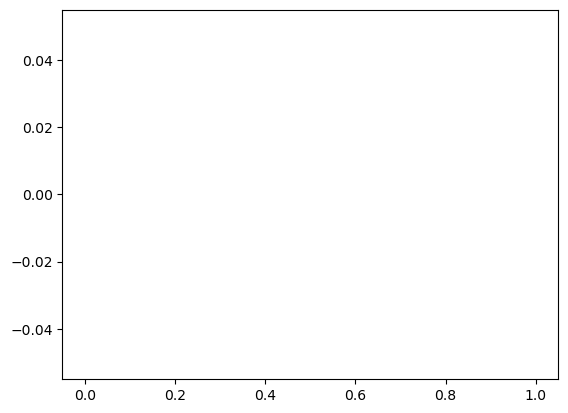

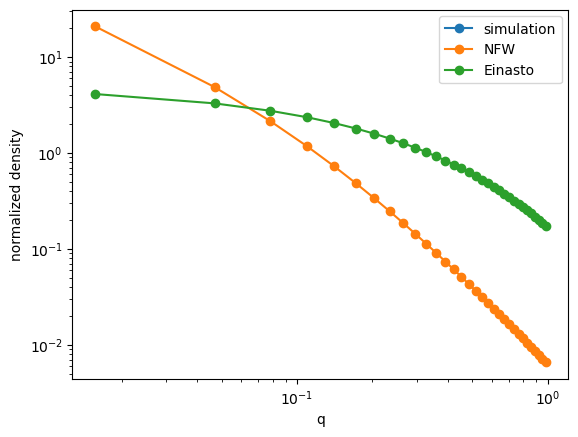

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


 18%|█▊        | 128/700 [00:00<00:00, 593.97it/s]

Setting k from 1.0 to 1.2786615184727914


  0%|          | 0/700 [00:00<?, ?it/s]627.15it/s]

Setting k from 1.0 to 1.2380758096170688


 25%|██▍       | 173/700 [00:00<00:00, 861.63it/s]

Setting k from 1.0 to 1.2026581174553928
Setting k from 1.0 to 1.1713446814818496


 50%|█████     | 353/700 [00:00<00:00, 865.18it/s]

Setting k from 1.0 to 1.1433604880274832


 21%|██        | 146/700 [00:00<00:00, 724.46it/s]

Setting k from 1.0 to 1.1181248272259217


 63%|██████▎   | 438/700 [00:00<00:00, 665.77it/s]

Setting k from 1.0 to 1.0951922528155011


 52%|█████▏    | 363/700 [00:00<00:00, 644.22it/s]

Setting k from 1.0 to 1.0742142054338777


100%|██████████| 700/700 [00:01<00:00, 686.69it/s]


Setting k from 1.0 to 1.054913232083926


 40%|████      | 280/700 [00:00<00:00, 527.83it/s]

Setting k from 1.0 to 1.0370651721277546


100%|██████████| 700/700 [00:01<00:00, 655.21it/s]


Setting k from 1.0 to 1.020486543741273


  0%|          | 0/700 [00:00<?, ?it/s]532.04it/s]

Setting k from 1.0 to 1.0050254197987296


100%|██████████| 700/700 [00:01<00:00, 624.96it/s]


Setting k from 1.0 to 0.9905547022692794


 36%|███▌      | 250/700 [00:00<00:00, 557.74it/s]

Setting k from 1.0 to 0.976967080822012


 93%|█████████▎| 649/700 [00:00<00:00, 684.37it/s]

Setting k from 1.0 to 0.9641711967660462


 73%|███████▎  | 512/700 [00:00<00:00, 613.48it/s]

Setting k from 1.0 to 0.9520886844495814


100%|██████████| 700/700 [00:01<00:00, 636.95it/s]


Setting k from 1.0 to 0.9406518613353702


  0%|          | 0/700 [00:00<?, ?it/s]562.46it/s]

Setting k from 1.0 to 0.9298019043592057


 19%|█▉        | 132/700 [00:00<00:00, 616.81it/s]

Setting k from 1.0 to 0.9194873954962401


 45%|████▌     | 317/700 [00:00<00:00, 587.70it/s]

Setting k from 1.0 to 0.9096631509257994


  0%|          | 0/700 [00:00<?, ?it/s]

Setting k from 1.0 to 0.9002892703754356


  0%|          | 0/700 [00:00<?, ?it/s]580.47it/s]

Setting k from 1.0 to 0.8913303590984867


 87%|████████▋ | 610/700 [00:00<00:00, 673.94it/s]

Setting k from 1.0 to 0.8827548864445609


 45%|████▌     | 316/700 [00:00<00:00, 555.60it/s]

Setting k from 1.0 to 0.8745346534231188


100%|██████████| 700/700 [00:01<00:00, 674.04it/s]


mask 4488075 out of 56000000


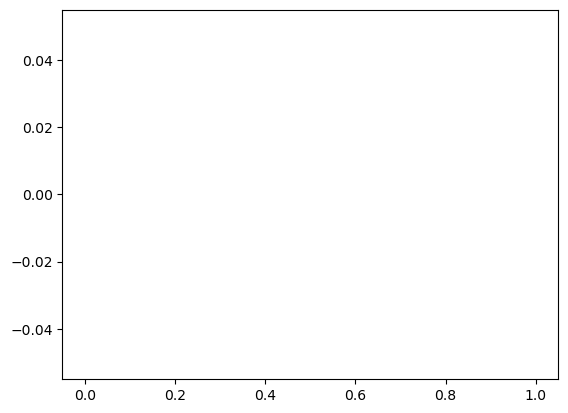

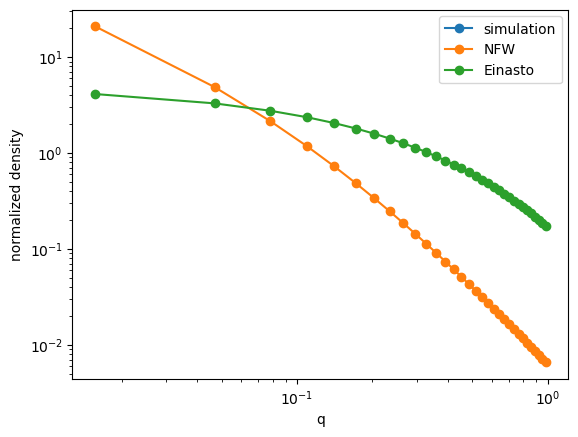

In [ ]:
bins = np.linspace(0,1,32+1)
plot_hist(32,bins,m0_min=1e-1,m0_max=1e0,A=1.00,alpha=5.00)
plot_hist(32,bins,m0_min=1e-1,m0_max=1e0,A=1.00,alpha=3.00)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


  0%|          | 0/700 [00:00<?, ?it/s]

Setting k from 1.0 to 1.2786615184727914
Setting k from 1.0 to 1.2380758096170688


 42%|████▏     | 293/700 [00:00<00:00, 987.92it/s]

Setting k from 1.0 to 1.2026581174553928
Setting k from 1.0 to 1.1713446814818496


100%|██████████| 700/700 [00:00<00:00, 973.80it/s] 


Setting k from 1.0 to 1.1433604880274832


 72%|███████▏  | 507/700 [00:00<00:00, 712.39it/s]

Setting k from 1.0 to 1.1181248272259217


 83%|████████▎ | 580/700 [00:00<00:00, 626.34it/s]

Setting k from 1.0 to 1.0951922528155011


  0%|          | 0/700 [00:00<?, ?it/s]441.27it/s]

Setting k from 1.0 to 1.0742142054338777


 27%|██▋       | 187/700 [00:00<00:00, 775.69it/s]

Setting k from 1.0 to 1.054913232083926


100%|██████████| 700/700 [00:01<00:00, 686.82it/s]


Setting k from 1.0 to 1.0370651721277546
Setting k from 1.0 to 1.020486543741273


 44%|████▍     | 308/700 [00:00<00:00, 575.02it/s]

Setting k from 1.0 to 1.0050254197987296


  0%|          | 0/700 [00:00<?, ?it/s]

Setting k from 1.0 to 0.9905547022692794


 30%|███       | 210/700 [00:00<00:00, 572.12it/s]

Setting k from 1.0 to 0.976967080822012


 23%|██▎       | 161/700 [00:00<00:00, 820.86it/s]

Setting k from 1.0 to 0.9641711967660462


  0%|          | 0/700 [00:00<?, ?it/s]

Setting k from 1.0 to 0.9520886844495814


100%|██████████| 700/700 [00:01<00:00, 626.21it/s]


Setting k from 1.0 to 0.9406518613353702


 22%|██▏       | 155/700 [00:00<00:00, 785.72it/s]

Setting k from 1.0 to 0.9298019043592057


 55%|█████▍    | 382/700 [00:00<00:00, 670.62it/s]

Setting k from 1.0 to 0.9194873954962401
Setting k from 1.0 to 0.9096631509257994


  0%|          | 0/700 [00:00<?, ?it/s]571.67it/s]

Setting k from 1.0 to 0.9002892703754356


  0%|          | 0/700 [00:00<?, ?it/s]623.93it/s]

Setting k from 1.0 to 0.8913303590984867


 94%|█████████▍| 657/700 [00:00<00:00, 721.32it/s]

Setting k from 1.0 to 0.8827548864445609


 36%|███▋      | 254/700 [00:00<00:00, 474.34it/s]

Setting k from 1.0 to 0.8745346534231188


100%|██████████| 700/700 [00:01<00:00, 671.09it/s]


mask 4488075 out of 56000000


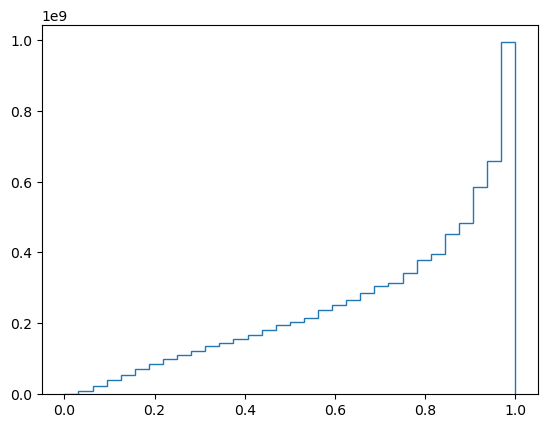

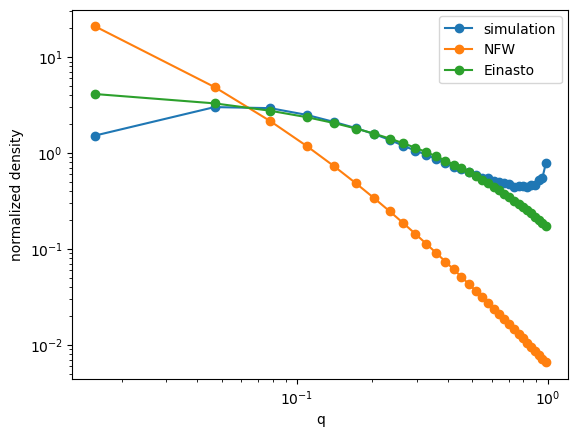

In [ ]:
plot_hist(32,bins,m0_min=1e-1,m0_max=1e0,A=1.00,alpha=2.00)

In [ ]:
plot_hist(32,bins,m0_min=1e-1,m0_max=1e0,A=1.00,alpha=3.0)
plot_hist(32,bins,m0_min=1e-1,m0_max=1e0,A=1.00,alpha=5.0)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


100%|██████████| 700/700 [00:00<00:00, 748.85it/s]


Setting k from 1.0 to 2.5932027420796806
Setting k from 1.0 to 3.0724672744211476


 17%|█▋        | 122/700 [00:00<00:00, 607.41it/s]

Setting k from 1.0 to 2.705510168683972
Setting k from 1.0 to 3.2055308746236566
Setting k from 1.0 to 2.382380223799591
Setting k from 1.0 to 2.944927227848717
Setting k from 1.0 to 2.822681448725485


 54%|█████▎    | 376/700 [00:00<00:00, 603.53it/s]

Setting k from 1.0 to 2.4855572673011386


100%|██████████| 700/700 [00:00<00:00, 1343.16it/s]


Setting k from 1.0 to 2.332409094387408


 34%|███▍      | 239/700 [00:00<00:00, 1191.03it/s]

Setting k from 1.0 to 2.235589327745572


 67%|██████▋   | 467/700 [00:00<00:00, 1054.99it/s]

Setting k from 1.0 to 2.1427886104356646


 74%|███████▎  | 516/700 [00:00<00:00, 1016.05it/s]

Setting k from 1.0 to 2.0538401091952965


 67%|██████▋   | 467/700 [00:00<00:00, 913.87it/s]

Setting k from 1.0 to 1.9685839161156011


 49%|████▉     | 342/700 [00:00<00:00, 640.05it/s]

Setting k from 1.0 to 1.886866761165456


 79%|███████▉  | 553/700 [00:00<00:00, 544.68it/s]

Setting k from 1.0 to 1.8085417366490102


 65%|██████▌   | 456/700 [00:00<00:00, 577.85it/s]

Setting k from 1.0 to 1.733468033101148


100%|██████████| 700/700 [00:01<00:00, 692.74it/s]


Setting k from 1.0 to 2.2834861241858255


100%|██████████| 700/700 [00:00<00:00, 701.28it/s]


Setting k from 1.0 to 2.188697180768673


100%|██████████| 700/700 [00:01<00:00, 562.99it/s]


Setting k from 1.0 to 2.097842985935702


  0%|          | 0/700 [00:00<?, ?it/s]548.24it/s]

Setting k from 1.0 to 2.0107602058015197


  0%|          | 0/700 [00:00<?, ?it/s]543.49it/s]

Setting k from 1.0 to 1.9272922865729147


100%|██████████| 700/700 [00:00<00:00, 701.39it/s]


Setting k from 1.0 to 1.847289173102973


100%|██████████| 700/700 [00:01<00:00, 652.60it/s]


Setting k from 1.0 to 1.7706070391281896


  0%|          | 0/700 [00:00<?, ?it/s]563.07it/s]

Setting k from 1.0 to 1.697108028703602


100%|██████████| 700/700 [00:01<00:00, 549.85it/s]


Setting k from 1.0 to 1.6615106861461042


  0%|          | 0/700 [00:00<?, ?it/s]

Setting k from 1.0 to 1.5925403338641293


100%|██████████| 700/700 [00:00<00:00, 779.15it/s]


Setting k from 1.0 to 1.5264329842300237


 19%|█▉        | 132/700 [00:00<00:00, 676.33it/s]

Setting k from 1.0 to 1.4630697922054414


 27%|██▋       | 187/700 [00:00<00:00, 627.61it/s]

Setting k from 1.0 to 1.402336846084232


 91%|█████████ | 638/700 [00:01<00:00, 721.81it/s]

Setting k from 1.0 to 1.3441249627067222


 63%|██████▎   | 439/700 [00:00<00:00, 462.24it/s]

Setting k from 1.0 to 1.2883294911747822


100%|██████████| 700/700 [00:01<00:00, 502.21it/s]


Setting k from 1.0 to 1.234850124714801


100%|██████████| 700/700 [00:01<00:00, 513.79it/s]


Setting k from 1.0 to 1.6266600083711211


  0%|          | 0/700 [00:00<?, ?it/s]395.27it/s]

Setting k from 1.0 to 1.5591363296155025


 80%|███████▉  | 558/700 [00:00<00:00, 611.95it/s]

Setting k from 1.0 to 1.4944156011809275


100%|██████████| 700/700 [00:01<00:00, 601.72it/s]


Setting k from 1.0 to 1.4323814708388583


100%|██████████| 700/700 [00:01<00:00, 462.27it/s]


Setting k from 1.0 to 1.3159315442982868
Setting k from 1.0 to 1.3729224162148532
Setting k from 1.0 to 1.2613063992745521


100%|██████████| 700/700 [00:01<00:00, 656.07it/s]


Setting k from 1.0 to 1.2089487783342643


 29%|██▉       | 204/700 [00:00<00:00, 595.19it/s]

Setting k from 1.0 to 1.1835907203503495


100%|██████████| 700/700 [00:01<00:00, 581.15it/s]


Setting k from 1.0 to 1.1344591260603434


 75%|███████▌  | 527/700 [00:00<00:00, 653.18it/s]

Setting k from 1.0 to 1.08736701511198


 45%|████▌     | 316/700 [00:00<00:00, 491.11it/s]

Setting k from 1.0 to 1.0422297272706198


100%|██████████| 700/700 [00:01<00:00, 555.51it/s]


Setting k from 1.0 to 0.9989661166011424


 50%|████▉     | 348/700 [00:00<00:00, 605.15it/s]

Setting k from 1.0 to 0.9574984055871677


 90%|█████████ | 630/700 [00:01<00:00, 558.79it/s]

Setting k from 1.0 to 0.917752045305878


 64%|██████▍   | 450/700 [00:00<00:00, 406.09it/s]

Setting k from 1.0 to 0.8796555814070695


100%|██████████| 700/700 [00:01<00:00, 630.79it/s]


Setting k from 1.0 to 1.1587645551283443


100%|██████████| 700/700 [00:01<00:00, 589.22it/s]


Setting k from 1.0 to 1.1106635105515896


100%|██████████| 700/700 [00:01<00:00, 557.69it/s]


Setting k from 1.0 to 1.020368650663964


  0%|          | 0/700 [00:00<?, ?it/s]523.89it/s]

Setting k from 1.0 to 1.0645591705505275


100%|██████████| 700/700 [00:01<00:00, 370.10it/s]


Setting k from 1.0 to 0.9780125070167552


 86%|████████▌ | 600/700 [00:01<00:00, 570.02it/s]

Setting k from 1.0 to 0.9374145934989172


100%|██████████| 700/700 [00:01<00:00, 605.10it/s]


Setting k from 1.0 to 0.8985019248733245


100%|██████████| 700/700 [00:01<00:00, 606.38it/s]


mask 9029345 out of 110250000


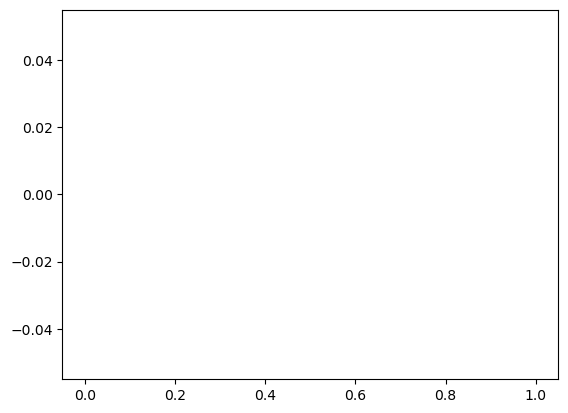

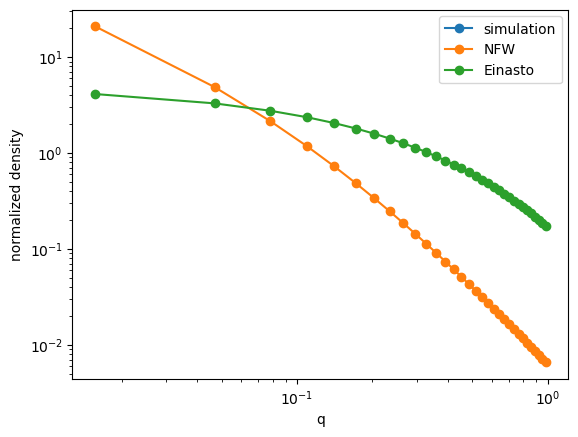

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


100%|██████████| 700/700 [00:01<00:00, 667.52it/s]


Setting k from 1.0 to 2.382380223799591
Setting k from 1.0 to 3.0724672744211476


 22%|██▏       | 152/700 [00:00<00:01, 330.38it/s]

Setting k from 1.0 to 2.4855572673011386


100%|██████████| 700/700 [00:01<00:00, 408.25it/s]


Setting k from 1.0 to 2.705510168683972


  0%|          | 0/700 [00:00<?, ?it/s]

Setting k from 1.0 to 2.944927227848717
Setting k from 1.0 to 3.2055308746236566


  0%|          | 0/700 [00:00<?, ?it/s]89.59it/s]]

Setting k from 1.0 to 2.5932027420796806
Setting k from 1.0 to 2.822681448725485


 48%|████▊     | 338/700 [00:00<00:00, 407.81it/s]

Setting k from 1.0 to 2.332409094387408


 15%|█▌        | 108/700 [00:00<00:01, 347.53it/s]

Setting k from 1.0 to 2.235589327745572


 84%|████████▍ | 588/700 [00:01<00:00, 398.74it/s]

Setting k from 1.0 to 2.1427886104356646


 46%|████▌     | 319/700 [00:00<00:00, 473.74it/s]

Setting k from 1.0 to 2.0538401091952965


 56%|█████▌    | 389/700 [00:00<00:00, 505.37it/s]

Setting k from 1.0 to 1.9685839161156011


 52%|█████▏    | 367/700 [00:00<00:00, 483.29it/s]

Setting k from 1.0 to 1.886866761165456


 48%|████▊     | 333/700 [00:00<00:00, 462.80it/s]

Setting k from 1.0 to 1.8085417366490102


 64%|██████▎   | 445/700 [00:00<00:00, 485.73it/s]

Setting k from 1.0 to 1.733468033101148


100%|██████████| 700/700 [00:01<00:00, 387.80it/s]


Setting k from 1.0 to 2.2834861241858255


100%|██████████| 700/700 [00:01<00:00, 444.30it/s]


Setting k from 1.0 to 2.0107602058015197


  0%|          | 0/700 [00:00<?, ?it/s]329.67it/s]

Setting k from 1.0 to 2.097842985935702
Setting k from 1.0 to 2.188697180768673


  0%|          | 0/700 [00:00<?, ?it/s]

Setting k from 1.0 to 1.9272922865729147


100%|██████████| 700/700 [00:01<00:00, 384.36it/s]


Setting k from 1.0 to 1.847289173102973


  6%|▌         | 40/700 [00:00<00:01, 391.50it/s]

Setting k from 1.0 to 1.7706070391281896
Setting k from 1.0 to 1.697108028703602


100%|██████████| 700/700 [00:01<00:00, 387.46it/s]


Setting k from 1.0 to 1.6615106861461042


 20%|██        | 140/700 [00:00<00:01, 479.91it/s]

Setting k from 1.0 to 1.5925403338641293


 47%|████▋     | 332/700 [00:00<00:00, 475.45it/s]

Setting k from 1.0 to 1.5264329842300237


  7%|▋         | 48/700 [00:00<00:01, 474.85it/s]]

Setting k from 1.0 to 1.4630697922054414


 62%|██████▏   | 431/700 [00:00<00:00, 402.71it/s]

Setting k from 1.0 to 1.402336846084232


 40%|███▉      | 278/700 [00:00<00:01, 382.05it/s]

Setting k from 1.0 to 1.3441249627067222


 19%|█▉        | 134/700 [00:00<00:01, 451.68it/s]

Setting k from 1.0 to 1.2883294911747822


 74%|███████▍  | 520/700 [00:01<00:00, 454.43it/s]

Setting k from 1.0 to 1.234850124714801


100%|██████████| 700/700 [00:01<00:00, 456.45it/s]


Setting k from 1.0 to 1.6266600083711211


100%|██████████| 700/700 [00:01<00:00, 404.67it/s]


Setting k from 1.0 to 1.5591363296155025


  0%|          | 0/700 [00:00<?, ?it/s]318.16it/s]

Setting k from 1.0 to 1.4944156011809275


  7%|▋         | 46/700 [00:00<00:01, 456.82it/s]]

Setting k from 1.0 to 1.4323814708388583


 19%|█▉        | 136/700 [00:00<00:01, 421.57it/s]

Setting k from 1.0 to 1.3729224162148532


 37%|███▋      | 260/700 [00:00<00:01, 424.17it/s]

Setting k from 1.0 to 1.3159315442982868


  0%|          | 0/700 [00:00<?, ?it/s]329.70it/s]

Setting k from 1.0 to 1.2613063992745521


100%|██████████| 700/700 [00:02<00:00, 337.64it/s]


Setting k from 1.0 to 1.2089487783342643


 22%|██▏       | 153/700 [00:00<00:01, 516.66it/s]

Setting k from 1.0 to 1.1835907203503495


100%|██████████| 700/700 [00:01<00:00, 522.43it/s]


Setting k from 1.0 to 1.1344591260603434


 12%|█▏        | 84/700 [00:00<00:01, 423.10it/s]

Setting k from 1.0 to 1.08736701511198


 59%|█████▉    | 413/700 [00:00<00:00, 546.21it/s]

Setting k from 1.0 to 1.0422297272706198


 18%|█▊        | 129/700 [00:00<00:00, 579.51it/s]

Setting k from 1.0 to 0.9989661166011424


 45%|████▍     | 314/700 [00:00<00:00, 608.57it/s]

Setting k from 1.0 to 0.9574984055871677


 73%|███████▎  | 509/700 [00:00<00:00, 622.72it/s]

Setting k from 1.0 to 0.917752045305878


 27%|██▋       | 192/700 [00:00<00:00, 581.67it/s]

Setting k from 1.0 to 0.8796555814070695


100%|██████████| 700/700 [00:01<00:00, 551.05it/s]


Setting k from 1.0 to 1.1587645551283443


100%|██████████| 700/700 [00:01<00:00, 525.59it/s]


Setting k from 1.0 to 1.1106635105515896


100%|██████████| 700/700 [00:01<00:00, 485.77it/s]


Setting k from 1.0 to 1.020368650663964


 13%|█▎        | 93/700 [00:00<00:01, 462.38it/s]

Setting k from 1.0 to 1.0645591705505275


 68%|██████▊   | 478/700 [00:01<00:00, 447.82it/s]

Setting k from 1.0 to 0.9780125070167552


100%|██████████| 700/700 [00:01<00:00, 531.48it/s]


Setting k from 1.0 to 0.9374145934989172


  0%|          | 0/700 [00:00<?, ?it/s]

Setting k from 1.0 to 0.8985019248733245


100%|██████████| 700/700 [00:01<00:00, 569.17it/s]


mask 9029345 out of 110250000


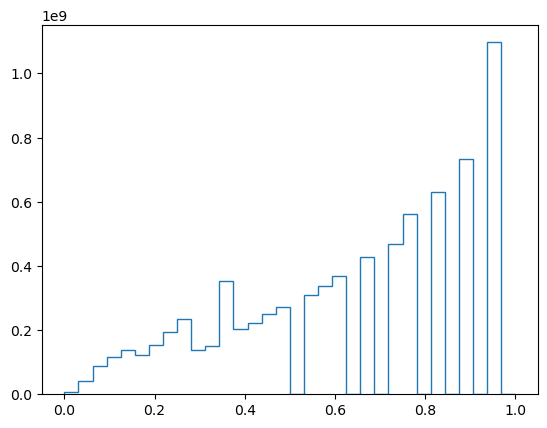

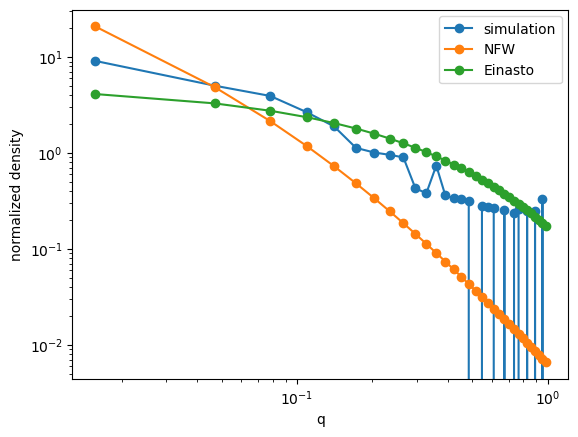

In [ ]:
q_bin = np.logspace(-2,0,64)
# q_bin = 32
plot_hist(q_bin, bins, m0_min=1e-1,m0_max=1e0,A=1.00,alpha=1.8)
plot_hist(q_bin, bins, m0_min=1e-1,m0_max=1e0,A=1.00,alpha=0.9)

In [ ]:
plot_hist(32,bins,m0_min=1e-1,m0_max=1e0,A=1.00,alpha=5.0)
plot_hist(32,bins,m0_min=1e-1,m0_max=1e0,A=1.00,alpha=3.0)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


100%|██████████| 700/700 [00:00<00:00, 796.86it/s]
Process SpawnPoolWorker-36:
Process SpawnPoolWorker-35:
Traceback (most recent call last):


KeyboardInterrupt: 

qmin_max 0.8286413273575838
qmin_min 2.4499704498568194e-17


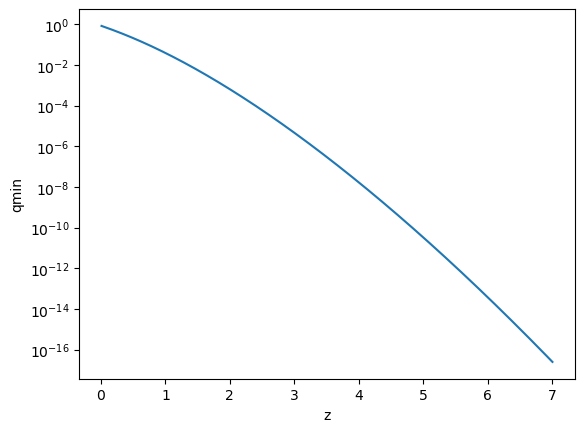

In [ ]:
import scipy.integrate as integrate


def calc_qmin(self,ma, redshift, dz=0.01, zmax=7, A=0.85, alpha=1.8, N_hermNa=5, Na_model='Na',
          m0_min=1e5):
    solver = sashimi_c.TidalStrippingSolverGeneralized(M0=1e12)
    zdist = np.arange(redshift+dz,zmax+dz,dz)
    a_0          = np.linspace(0.001,1./(1.+redshift),num=10000)
    integrand_0  = 1./np.sqrt(self.OmegaM/a_0**3+self.OmegaL)/self.H0/a_0
    time_0       = integrate.simps(integrand_0,x=a_0)
    a            = np.linspace(0.001,1./(1.+zdist),num=1000)
    integrand_a  = 1./np.sqrt(self.OmegaM/a**3+self.OmegaL)/self.H0/a
    time_a       = integrate.simps(integrand_a,x=a,axis=0)
    qmin         = A*np.exp(-(time_0-time_a)/(alpha*solver.tdynz(zdist)))
    return zdist, qmin

zdist, qmin = calc_qmin(sashimi_c.cosmology(),1e12,0)
plt.plot(zdist, qmin)
plt.xlabel('z')
plt.ylabel('qmin')
plt.yscale('log')
print("qmin_max", np.max(qmin))
print("qmin_min", np.min(qmin))
plt.show()


params: A=1, alpha=1.8
qmin_max 0.9748721498324515
params: A=1, alpha=1.8
qmin_max 0.9748721498324515
params: A=1, alpha=1.8
qmin_max 0.9748721498324515
params: A=1, alpha=1.8
qmin_max 0.9748721498324515
params: A=1, alpha=2.0
qmin_max 0.9773562561543622
params: A=1, alpha=2.0
qmin_max 0.9773562561543622
params: A=1, alpha=2.0
qmin_max 0.9773562561543622
params: A=1, alpha=2.0
qmin_max 0.9773562561543622
params: A=1, alpha=2.2
qmin_max 0.9793934141999016
params: A=1, alpha=2.2
qmin_max 0.9793934141999016
params: A=1, alpha=2.2
qmin_max 0.9793934141999016
params: A=1, alpha=2.2
qmin_max 0.9793934141999016
params: A=1, alpha=2.4
qmin_max 0.981094289125045
params: A=1, alpha=2.4
qmin_max 0.981094289125045
params: A=1, alpha=2.4
qmin_max 0.981094289125045
params: A=1, alpha=2.4
qmin_max 0.981094289125045


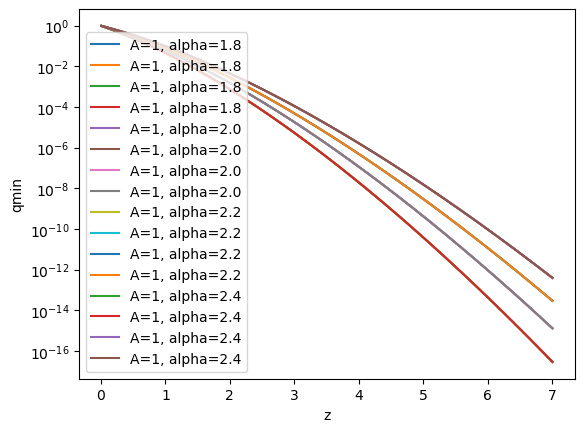

In [ ]:
# plot qmin for various alpha and A
def plot_qmin(zdist, qmin):
    A = [1,1,1,1]
    alpha = [1.8, 2.0, 2.2, 2.4]
    for a in alpha:
        for b in A:
            zdist, qmin = calc_qmin(sashimi_c.cosmology(), 1e12, 0, A=b, alpha=a)
            plt.plot(zdist, qmin, label=f'A={b}, alpha={a}')
            print(f"params: A={b}, alpha={a}")
            print("qmin_max", np.max(qmin))
    plt.xlabel('z')
    plt.ylabel('qmin')
    plt.yscale('log')
    
    plt.legend()
    plt.show()

# plot qmin for various alpha and A
plot_qmin(zdist, qmin)

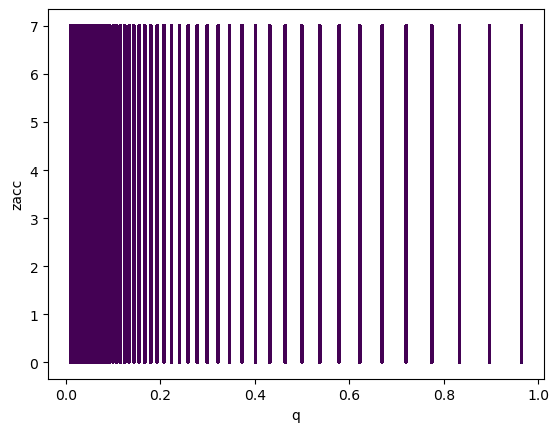

In [ ]:
# 2D plot for q and zacc
def plot_2d_hist(q, zacc, bins):
    q = np.array(q).reshape(-1)
    zacc = np.array(zacc).reshape(-1)
    weight = results[-4].reshape(-1)
    plt.scatter(q, zacc, c=weight, s=1, cmap='viridis', alpha=0.5)
    plt.xlabel('q')
    plt.ylabel('zacc')
    

plot_2d_hist(results[-1], results[1], bins=(64, 64)); plt.show()

In [ ]:
# create dataframe from results
import pandas as pd
df = pd.DataFrame({colname: np.array(result).reshape(-1) for colname, result in zip(COLNAMES, results)})
df


,ma200,z_acc,rs_acc,rhos_acc,m_z0,rs_z0,rhos_z0,ct_z0,weight_combined,density,survive,q
0,1.000000e-02,0.01,2.992851e-07,1.568475e+16,1.062273e-02,2.948366e-07,1.607250e+16,19.134510,0.000000e+00,0.000000e+00,True,0.010379
1,1.061823e-02,0.01,3.058193e-07,1.562096e+16,1.127960e-02,3.012703e-07,1.600741e+16,19.104040,0.000000e+00,0.000000e+00,True,0.010379
2,1.127468e-02,0.01,3.124952e-07,1.555753e+16,1.197710e-02,3.078436e-07,1.594270e+16,19.073696,0.000000e+00,0.000000e+00,True,0.010379
3,1.197171e-02,0.01,3.193161e-07,1.549446e+16,1.271772e-02,3.145595e-07,1.587836e+16,19.043405,0.000000e+00,0.000000e+00,True,0.010379
4,1.271184e-02,0.01,3.262851e-07,1.543176e+16,1.350414e-02,3.214211e-07,1.581438e+16,19.013195,0.000000e+00,0.000000e+00,True,0.010379
...,...,...,...,...,...,...,...,...,...,...,...,...
110249995,7.866682e+10,7.00,2.334455e-03,4.103215e+17,1.215569e+08,1.395715e-04,3.983911e+18,4.543808,1.221184e-15,6.942586e-14,True,0.964755
110249996,8.353023e+10,7.00,2.384404e-03,4.091811e+17,1.286654e+08,1.423767e-04,3.975389e+18,4.539429,6.098576e-16,3.467117e-14,True,0.964755
110249997,8.869432e+10,7.00,2.435423e-03,4.080440e+17,1.361893e+08,1.452382e-04,3.966887e+18,4.535051,3.006343e-16,1.709143e-14,True,0.964755
110249998,9.417766e+10,7.00,2.487533e-03,4.069103e+17,1.441530e+08,1.481571e-04,3.958406e+18,4.530674,1.463158e-16,8.318235e-15,True,0.964755


In [ ]:
df["log10_weight_combined"] = np.log10(df["weight_combined"])
df.plot.scatter(x='q', y='z_acc', c="log10_weight_combined", 
                colormap='viridis', linewidth=0, s=1)

<Axes: xlabel='q', ylabel='z_acc'>

Error in callback <function _draw_all_if_interactive at 0x140c71ee0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x140c83ba0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
df["log10_weight_combined"] = np.log10(df["weight_combined"])
# df.plot.scatter(x='q', y='m_z0', c="log10_weight_combined", 
#                 colormap='viridis', linewidth=0, s=1, logy=True)
# 2D histogram
plt.hist2d(df["q"], np.log10(df["m_z0"]), bins=128, weights=df["weight_combined"], cmap='viridis')
plt.xlabel('q')
plt.ylabel('log10(m_z0)')
plt.colorbar()
plt.show()


In [ ]:
df["log10_weight_combined"] = np.log10(df["weight_combined"])
# df.plot.scatter(x='q', y='m_z0', c="log10_weight_combined", 
#                 colormap='viridis', linewidth=0, s=1, logy=True)
# 2D histogram
mask = df["m_z0"] > m0_min
plt.hist2d(
    df["q"][mask], 
    np.log10(df["m_z0"][mask]), 
    bins=128, 
    weights=df["weight_combined"][mask], cmap='viridis')
plt.xlabel('q')
plt.ylabel('log10(m_z0)')
plt.colorbar()
plt.show()


In [ ]:
# 2D histogram of q and z_acc
plt.hist2d(df["q"], df["z_acc"], bins=256, weights=df["weight_combined"], cmap='viridis')
plt.xlabel('q')
plt.ylabel('z_acc')
plt.colorbar()
plt.show()

In [ ]:
np.log10(df["weight_combined"].sum())

In [ ]:
import sashimi_c
sh = sashimi_c.subhalo_properties()
ret = sh.subhalo_properties_calc(1e12,logmamin=-2,N_herm=5,A=0.85,alpha=1.8)


In [ ]:
np.log10(ret[-2].sum())

In [ ]:
redshift = 0
M0 = 1e12
Oz    = sh.OmegaM*(1.+redshift)**3/sh.g(redshift)
Mvir0 = sh.Mvir_from_M200_fit(M0,redshift)
rvir_host = np.cbrt(3.*Mvir0/(4.*np.pi*sh.rhocrit0*sh.g(redshift) \
                               *sh.Delc(Oz-1)))
print(rvir_host/sh.kpc)  # ~ 277 kpc
print(sh.conc200(M0,redshift))  # ~ 9.0

## About the discreatization of the spatial distribution $P(q)$

My naive implementation of the discreate distribution $P(q)$ is that

$$
\int P(q)dq \to \sum_i P(q_i)\Delta q_i \equiv w_i
$$

However, this is not correct if we use sparse grid. To improve this definition, we redifine the weight like this:

$$
w_i = \int_{q_i-\Delta_q/2}^{q_i+\Delta_q/2} P(q)dq
$$

where, since P(q) comes from the NFW profile, we can use that 

$$
\int_0^q P(q)dq \propto M(q) \propto \ln(1+r/r_s) - \frac{r/r_s}{1+r/r_s} = \ln(1+cq) - \frac{cq}{1+cq}
$$

Here we define the grid as a array of $q_i$ like $q_0,q_1,q_2,...,q_n$ and the width of the grid as $\Delta q_i = q_{i+1}-q_i$. The weight of each grid is then defined as

$$
w_i = \int_{q_i}^{q_i+1} P(q)dq = \left(\ln(1+cq_{i+1}) - \frac{cq_{i+1}}{1+cq_{i+1}}\right) - \left( \ln(1+cq_i) - \frac{cq_i}{1+cq_i} \right)

Point is that the range of $q$ is not $[0,1]$ but $[q_\mathrm{min}(z),1]$ where $q_\mathrm{min}(z)$ is the minimum value of $q$ at redshift $z$. 

In [ ]:
import numpy as np

arr = np.arange(100).reshape(-1,1)
%timeit arr * np.ones((100,100,100))
%timeit np.broadcast_to(arr,(100,100,100))